In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

import analyze2p.decoding as dec

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Aggregate

In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(tick_labelsize=6, axis_labelsize=6, lw_axes=0.25)

In [3]:
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --

In [4]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
             datakey  cell
visual_area               
Li              3354  3354
Lm              3942  3942
V1              4061  4061


In [5]:
# sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
#                                                   create_new=False,
#                                                   return_cells=True, return_missing=True)
# all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
#                     .drop_duplicates().groupby(['visual_area']).count().reset_index()

# print(all_cell_counts.groupby(['visual_area']).sum())

In [6]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [7]:
experiment='blobs'
trial_epoch = 'stimulus' #'stimulus'
responsive_test='ROC' #'ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


# Output plotting

In [8]:
#aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'objects_metrics_MIGR')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
    
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 
                       'final', '{}-{}'.format(responsive_test, trial_epoch))
print(dst_dir)
if not os.path.exists(os.path.join(dst_dir,'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(data_id)


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus
traces001|dff_ROC-0.05


In [9]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus'

In [10]:
# exclude =[] # ['20190627_JC091_fov1', '20191111_JC120_fov1', '20190506_JC080_fov1']

# NDATA0 = NDATA_[~(NDATA_.datakey.isin(exclude))].copy()

In [11]:
filter_rfs=False
if filter_rfs:
    cells_overlap = dec.get_cells_with_overlap(assigned_cells, sdata, 
                                 greater_than=False,
                                overlap_thr=0.0)
    NDATA0_rf = aggr.get_neuraldata_for_included_cells(cells_overlap, NDATA0)
    curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
else:
    curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()

n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

In [12]:
NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

datakey  cell
visual_area               
Li               583   583
Lm              1048  1048
V1              1259  1259

In [13]:
# curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
# curr_counts

In [14]:
SDF, incorrect_stims = aggr.check_sdfs(n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])


In [15]:
min_ncells=10
enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>min_ncells]\
                [['visual_area', 'datakey']].drop_duplicates().values]
correct_stims = SDF['datakey'].unique()
# -----------------------------------
NDATA_ = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in enough_cells and dk in correct_stims])

In [16]:
NDATA_[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

datakey  cell
visual_area               
Li               472   472
Lm              1016  1016
V1              1257  1257

In [17]:
NDATA1 = NDATA_.copy()
curr_counts = NDATA1[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA_all = pd.concat([g for (va, dk), g in NDATA1.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


In [18]:
NDATA_all[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

datakey  cell
visual_area               
Li               247   247
Lm               531   531
V1              1010  1010

In [19]:
NDATA_all[['visual_area', 'datakey', 'cell']].drop_duplicates()\
        .groupby(['visual_area', 'datakey'])['cell'].count()

visual_area  datakey            
Li           20190422_JC076_fov1     29
             20190606_JC091_fov1     48
             20190607_JC091_fov1     52
             20190612_JC099_fov1     41
             20191018_JC113_fov1     47
             20191111_JC120_fov1     30
Lm           20190422_JC076_fov1     22
             20190509_JC078_fov1     48
             20190513_JC078_fov1     73
             20190517_JC083_fov1     64
             20190525_JC084_fov1     91
             20190603_JC080_fov1    120
             20190618_JC097_fov1     41
             20190627_JC091_fov1     72
V1           20190501_JC076_fov1     33
             20190511_JC083_fov1     88
             20190517_JC083_fov1     13
             20190522_JC084_fov1    107
             20190613_JC097_fov1    120
             20190616_JC097_fov1    185
             20190617_JC097_fov1    182
             20190622_JC085_fov1    196
             20191006_JC110_fov1     86
Name: cell, dtype: int64

In [245]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [246]:
exclude=[] # wrong configs
offset_type = 'none'
lcorrection = 'exclude'
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)

NDATA = NDATA_all.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection)
print(ixdf['n_cells'].min())

offset-none_lum-exclude


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:642: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:642: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:642: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:642: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

13


In [262]:
NDATA[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               277   277
Lm               531   531
V1              1010  1010

In [264]:
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count()

cell
visual_area datakey                  
Li          20190422_JC076_fov1    29
            20190607_JC091_fov1    52
            20190612_JC099_fov1    41
            20190614_JC091_fov1    78
            20191018_JC113_fov1    47
            20191111_JC120_fov1    30
Lm          20190422_JC076_fov1    22
            20190509_JC078_fov1    48
            20190513_JC078_fov1    73
            20190517_JC083_fov1    64
            20190525_JC084_fov1    91
            20190603_JC080_fov1   120
            20190618_JC097_fov1    41
            20190627_JC091_fov1    72
V1          20190501_JC076_fov1    33
            20190511_JC083_fov1    88
            20190517_JC083_fov1    13
            20190522_JC084_fov1   107
            20190613_JC097_fov1   120
            20190616_JC097_fov1   185
            20190617_JC097_fov1   182
            20190622_JC085_fov1   196
            20191006_JC110_fov1    86

In [247]:
mean_per_cell = NDATA.groupby(['visual_area', 'datakey', 'cell', 'config']).mean()\
                    .reset_index()
len(mean_per_cell['config'].unique())

50

In [248]:
sdf_master = aggr.get_master_sdf(experiment='blobs', images_only=False)
mean_per_cell['size'] = [sdf_master.loc[cfg]['size'] \
                             for cfg in mean_per_cell['config'].values]
mean_per_cell['morphlevel'] = [sdf_master.loc[cfg]['morphlevel'] \
                             for cfg in mean_per_cell['config'].values]

In [249]:
mean_per_fov = mean_per_cell.groupby(['visual_area', 'datakey', 'config', 'size', 'morphlevel'])\
                .median().reset_index()
mean_per_fov

visual_area              datakey     config  size  morphlevel   cell  \
0             Li  20190422_JC076_fov1  config001  10.0          -1  277.0   
1             Li  20190422_JC076_fov1  config002  20.0          -1  277.0   
2             Li  20190422_JC076_fov1  config003  30.0          -1  277.0   
3             Li  20190422_JC076_fov1  config004  40.0          -1  277.0   
4             Li  20190422_JC076_fov1  config005  50.0          -1  277.0   
...          ...                  ...        ...   ...         ...    ...   
1145          V1  20191006_JC110_fov1  config046  10.0         106  184.5   
1146          V1  20191006_JC110_fov1  config047  20.0         106  184.5   
1147          V1  20191006_JC110_fov1  config048  30.0         106  184.5   
1148          V1  20191006_JC110_fov1  config049  40.0         106  184.5   
1149          V1  20191006_JC110_fov1  config050  50.0         106  184.5   

           trial  response  
0     751.133333  0.074493  
1     748.500000  0.038284  
2     752.033333  0.046387  
3     755.666667  0.042965  
4     749.300000  0.046986  
...          ...       ...  
1145  833.823529  0.056127  
1146  835.970588  0.060342  
1147  836.470588  0.042684  
1148  837.588235  0.030281  
1149  840.575758  0.020720  

[1150 rows x 8 columns]

In [250]:
print('size_tol', ixdf[(ixdf['size_tol']>=1) | (ixdf['size_tol']<0)].shape)
print('morph_sel', ixdf[(ixdf['morph_sel']>=1) | (ixdf['morph_sel']<0)].shape)
print('sparseness_morphs', ixdf[(ixdf['sparseness_morphs']>1) | (ixdf['sparseness_morphs']<0)].shape)

size_tol (0, 17)
morph_sel (0, 17)
sparseness_morphs (0, 17)


In [252]:
ixdf[ixdf['lum_size_pval']<0.05]

Empty DataFrame
Columns: [morph_sel, best_size, size_tol, best_morphlevel, size_tol_corr, best_morphlevel, sparseness_total, sparseness_morphs, sparseness_anchors, size_sel, lum_sel, lum_size_cc, lum_size_pval, cell, visual_area, datakey, n_cells]
Index: []

In [259]:
min_ncells=5
print(ixdf.shape)
lum_cols = [k for k in ixdf.columns if 'lum' in k]
if lcorrection=='normalize':
    for k in lum_cols:
        ixdf = ixdf.drop(k, 1)
for va, vg in ixdf.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    ixdf.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]
DF = ixdf[ixdf['n_cells']>=min_ncells].copy().dropna()
print(ixdf.shape, ixdf.dropna().shape, DF.shape)

(1067, 18)
(1067, 18) (1067, 18) (1067, 18)


In [254]:
# Get means by FOV
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

In [274]:
ncells_by_fov.groupby('visual_area')['n_cells'].sum()

visual_area
Li    132
Lm    233
V1    702
Name: n_cells, dtype: int64

[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.177334   0.480528  0.413034  0.496538     0.059240   
1          Lm           0.227110   0.486016  0.356252  0.589160    -0.074901   
2          V1           0.222451   0.399453  0.409172  0.565322     0.191890   

   lum_size_pval  sparseness_total  size_tol_corr  sparseness_morphs_std  \
0       0.511797          0.179446       0.182181               0.020233   
1       0.469363          0.228518       0.132989               0.021012   
2       0.446552          0.210584       0.217636               0.018896   

   morph_sel_std  size_tol_std  lum_sel_std  lum_size_cc_std  \
0       0.061100      0.072636     0.116209         0.129479   
1       0.056729      0.033466     0.089617         0.179387   
2       0.048340      0.038285     0.046892         0.258444   

   lum_size_pval_std  sparseness_total_std  size_tol_corr_std  
0           0.110789              0.012906 

<IPython.core.display.Javascript object>


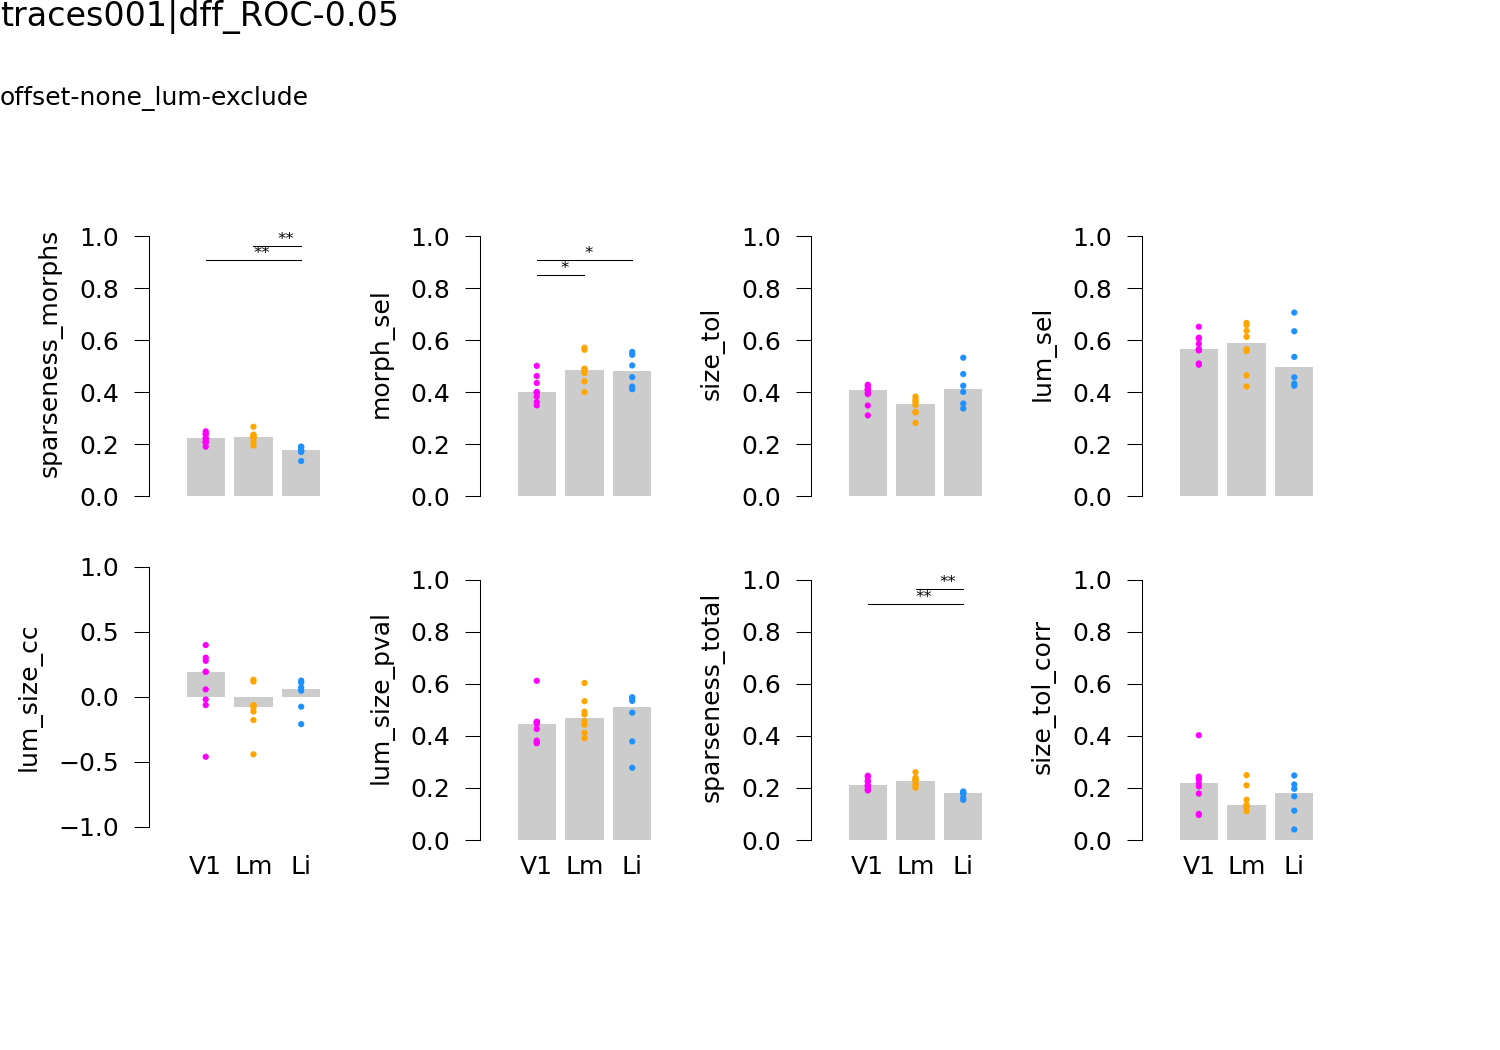

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None`

sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.17  0.02  0.14  0.17  0.18  0.19  0.19
Lm             8.0  0.23  0.02  0.20  0.22  0.23  0.23  0.27
V1             9.0  0.22  0.02  0.19  0.21  0.22  0.24  0.25
morph_sel ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.48  0.06  0.41  0.43  0.48  0.53  0.55
Lm             8.0  0.49  0.06  0.40  0.47  0.49  0.51  0.57
V1             9.0  0.41  0.05  0.35  0.38  0.40  0.44  0.50
size_tol ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.42  0.07  0.34  0.37  0.41  0.46  0.53
Lm             8.0  0.35  0.03  0.28  0.32  0.36  0.37  0.38
V1             9.0  0.39  0.04  0.

In [285]:
%matplotlib notebook
plot_params=['sparseness_morphs', 'morph_sel', 'size_tol', 
             'lum_sel', 'lum_size_cc','lum_size_pval', 
             'sparseness_total', 'size_tol_corr', ]

mean_type='median'
multi_comp_test='fdr_by' #'fdr_bh'
markersize = 3
fw=5
ymax=0.8 + 0.04
plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(fw, 3.5), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.1
    y_loc = np.ceil(plotdf[metric].max())*0.85
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='bar', mean_type=mean_type, aspect=2)
    if metric != 'lum_size_cc':
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.6)
sns.despine(offset=8, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byFOV_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.png' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
# print(dst_dir, figname)

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))


[median]:
  visual_area  sparseness_morphs  morph_sel  size_tol   lum_sel  lum_size_cc  \
0          Li           0.178440   0.469059  0.414240  0.549841     0.032260   
1          Lm           0.227525   0.481751  0.340162  0.599269    -0.109951   
2          V1           0.210161   0.409344  0.409202  0.571431     0.129368   

   lum_size_pval  sparseness_total  size_tol_corr  sparseness_morphs_std  \
0       0.486696          0.175677       0.187611               0.086566   
1       0.444371          0.226391       0.147348               0.093115   
2       0.444994          0.206382       0.204187               0.095394   

   morph_sel_std  size_tol_std  lum_sel_std  lum_size_cc_std  \
0       0.136680      0.150859     0.196452         0.490602   
1       0.158641      0.135918     0.171170         0.504902   
2       0.165591      0.161782     0.167034         0.506628   

   lum_size_pval_std  sparseness_total_std  size_tol_corr_std  
0           0.275694              0.084206 

<IPython.core.display.Javascript object>


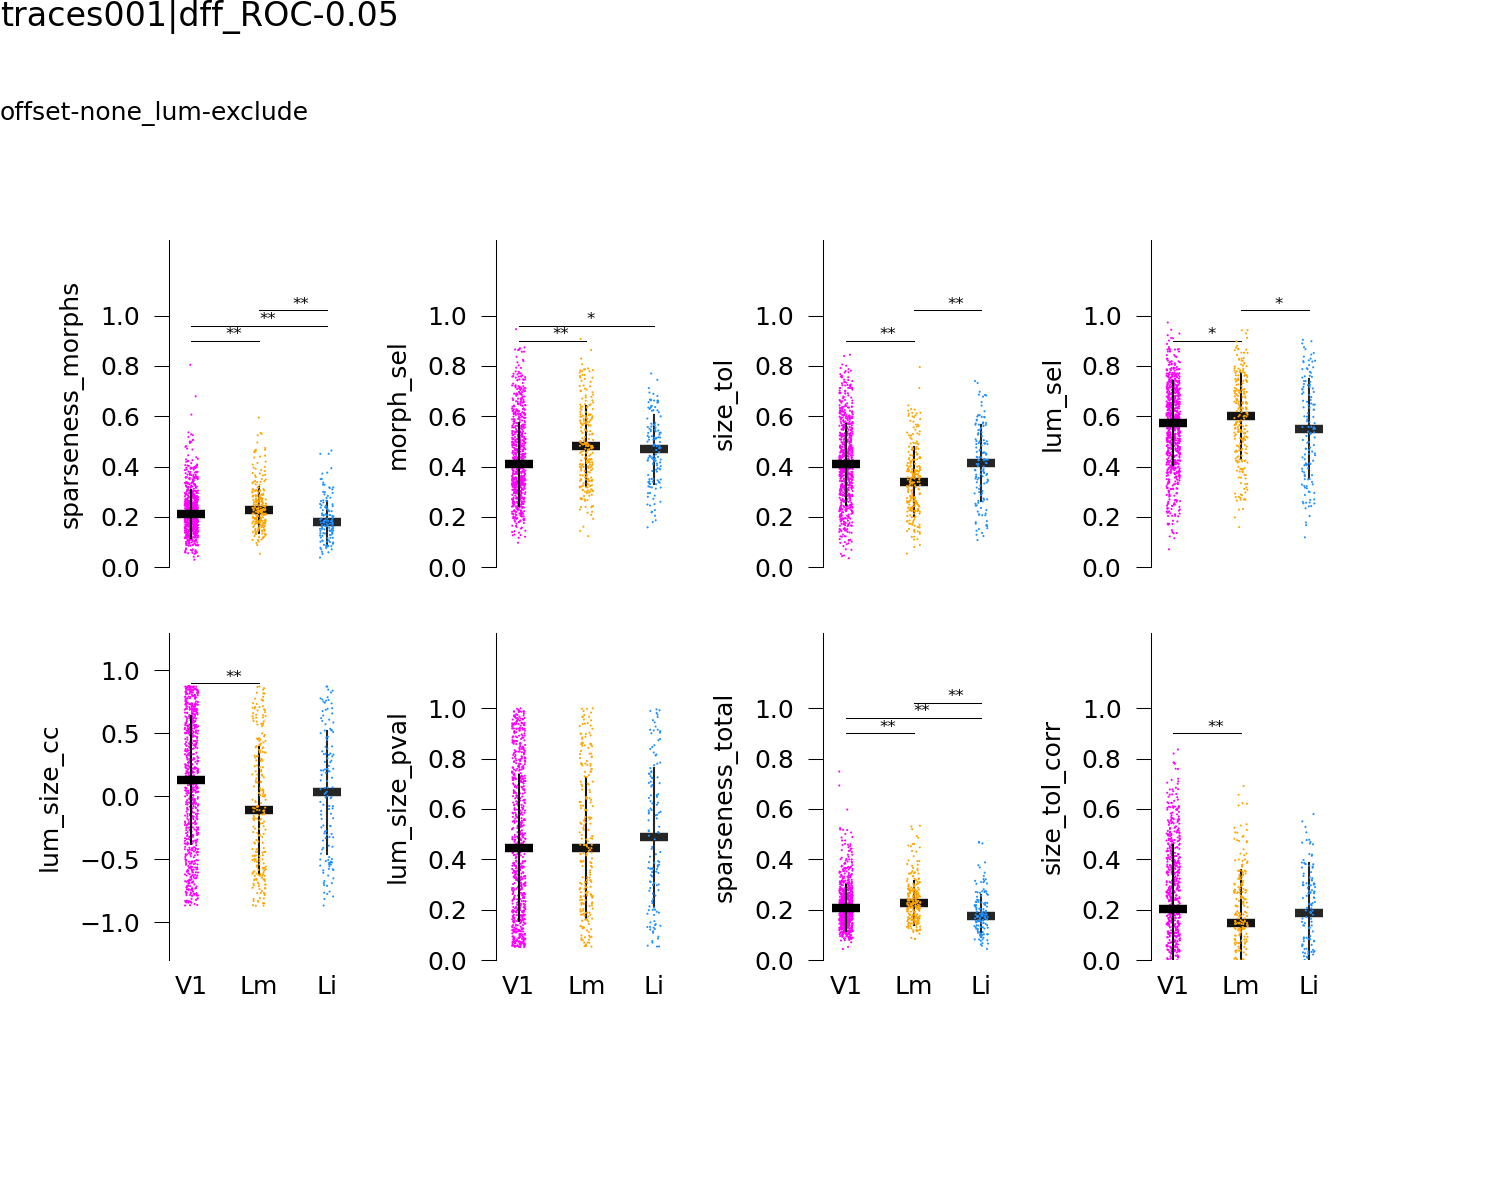

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:906: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/li

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus metrics_byCELL_offset-none_lum-exclude


In [286]:
%matplotlib notebook
mean_type = 'median'
multi_comp_test='fdr_bh' #'fdr_bh'

fw=5
markersize = 1 

plotdf = DF.dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.3
    y_loc = np.ceil(plotdf[metric].max())*0.9
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='point', mean_type=mean_type)
    if metric != 'lum_size_cc':
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byCELL_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.png' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)


In [281]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

In [282]:
tradeoff

pearson_r  pearson_p visual_area               datkey n_cells
0   -0.261376   0.294793          Li  20190422_JC076_fov1      18
1   -0.601621   0.001149          Li  20190607_JC091_fov1      26
2   -0.274756   0.303072          Li  20190612_JC099_fov1      16
3    0.072496   0.665352          Li  20190614_JC091_fov1      38
4   -0.139746   0.505260          Li  20191018_JC113_fov1      25
5   -0.001887   0.996156          Li  20191111_JC120_fov1       9
6    0.157638   0.559847          Lm  20190422_JC076_fov1      16
7    0.057897   0.831344          Lm  20190509_JC078_fov1      16
8    0.169461   0.398103          Lm  20190513_JC078_fov1      27
9   -0.473912   0.000582          Lm  20190517_JC083_fov1      49
10   0.049941   0.782549          Lm  20190525_JC084_fov1      33
11  -0.198728   0.134788          Lm  20190603_JC080_fov1      58
12  -0.107459   0.634084          Lm  20190618_JC097_fov1      22
13  -0.170804   0.595588          Lm  20190627_JC091_fov1      12
14  -0.362693   0.302998          V1  20190501_JC076_fov1      10
15   0.034141   0.790519          V1  20190511_JC083_fov1      63
16  -0.296227   0.376426          V1  20190517_JC083_fov1      11
17   0.124790   0.255149          V1  20190522_JC084_fov1      85
18  -0.007722   0.947937          V1  20190613_JC097_fov1      74
19   0.125265   0.144700          V1  20190616_JC097_fov1     137
20   0.187985   0.020383          V1  20190617_JC097_fov1     152
21   0.033869   0.726618          V1  20190622_JC085_fov1     109
22  -0.016443   0.899907          V1  20191006_JC110_fov1      61

<IPython.core.display.Javascript object>


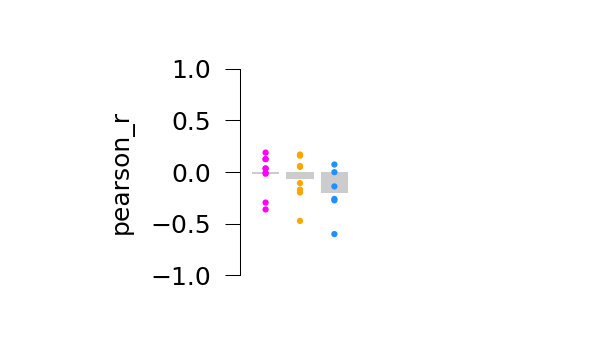

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,


             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0 -0.20  0.24 -0.60 -0.27 -0.20 -0.04  0.07
Lm             8.0 -0.06  0.22 -0.47 -0.18 -0.03  0.08  0.17
V1             9.0 -0.02  0.19 -0.36 -0.02  0.03  0.12  0.19


IndexError: index -1 is out of bounds for axis 0 with size 0

In [300]:
metric = 'pearson_r'
y_loc=0.4
fig, ax = pl.subplots(figsize=(2,1.15), dpi=150)
ax, sts = pplot.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                posthoc=multi_comp_test,
                                sig_fontsize=4, jitter=False, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_type='mean', mean_style='bar', return_stats=True)
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_xticks('')
print(tradeoff.groupby('visual_area')[metric].describe().round(2))
ax.set_ylim([-1, 1])
sns.despine(trim=True, ax=ax, bottom=True)
pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = 'tradeoff-pearsonr_%s' % filter_str

pl.savefig(os.path.join(dst_dir, '%s.png' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)
print(sts.round(2))

<IPython.core.display.Javascript object>


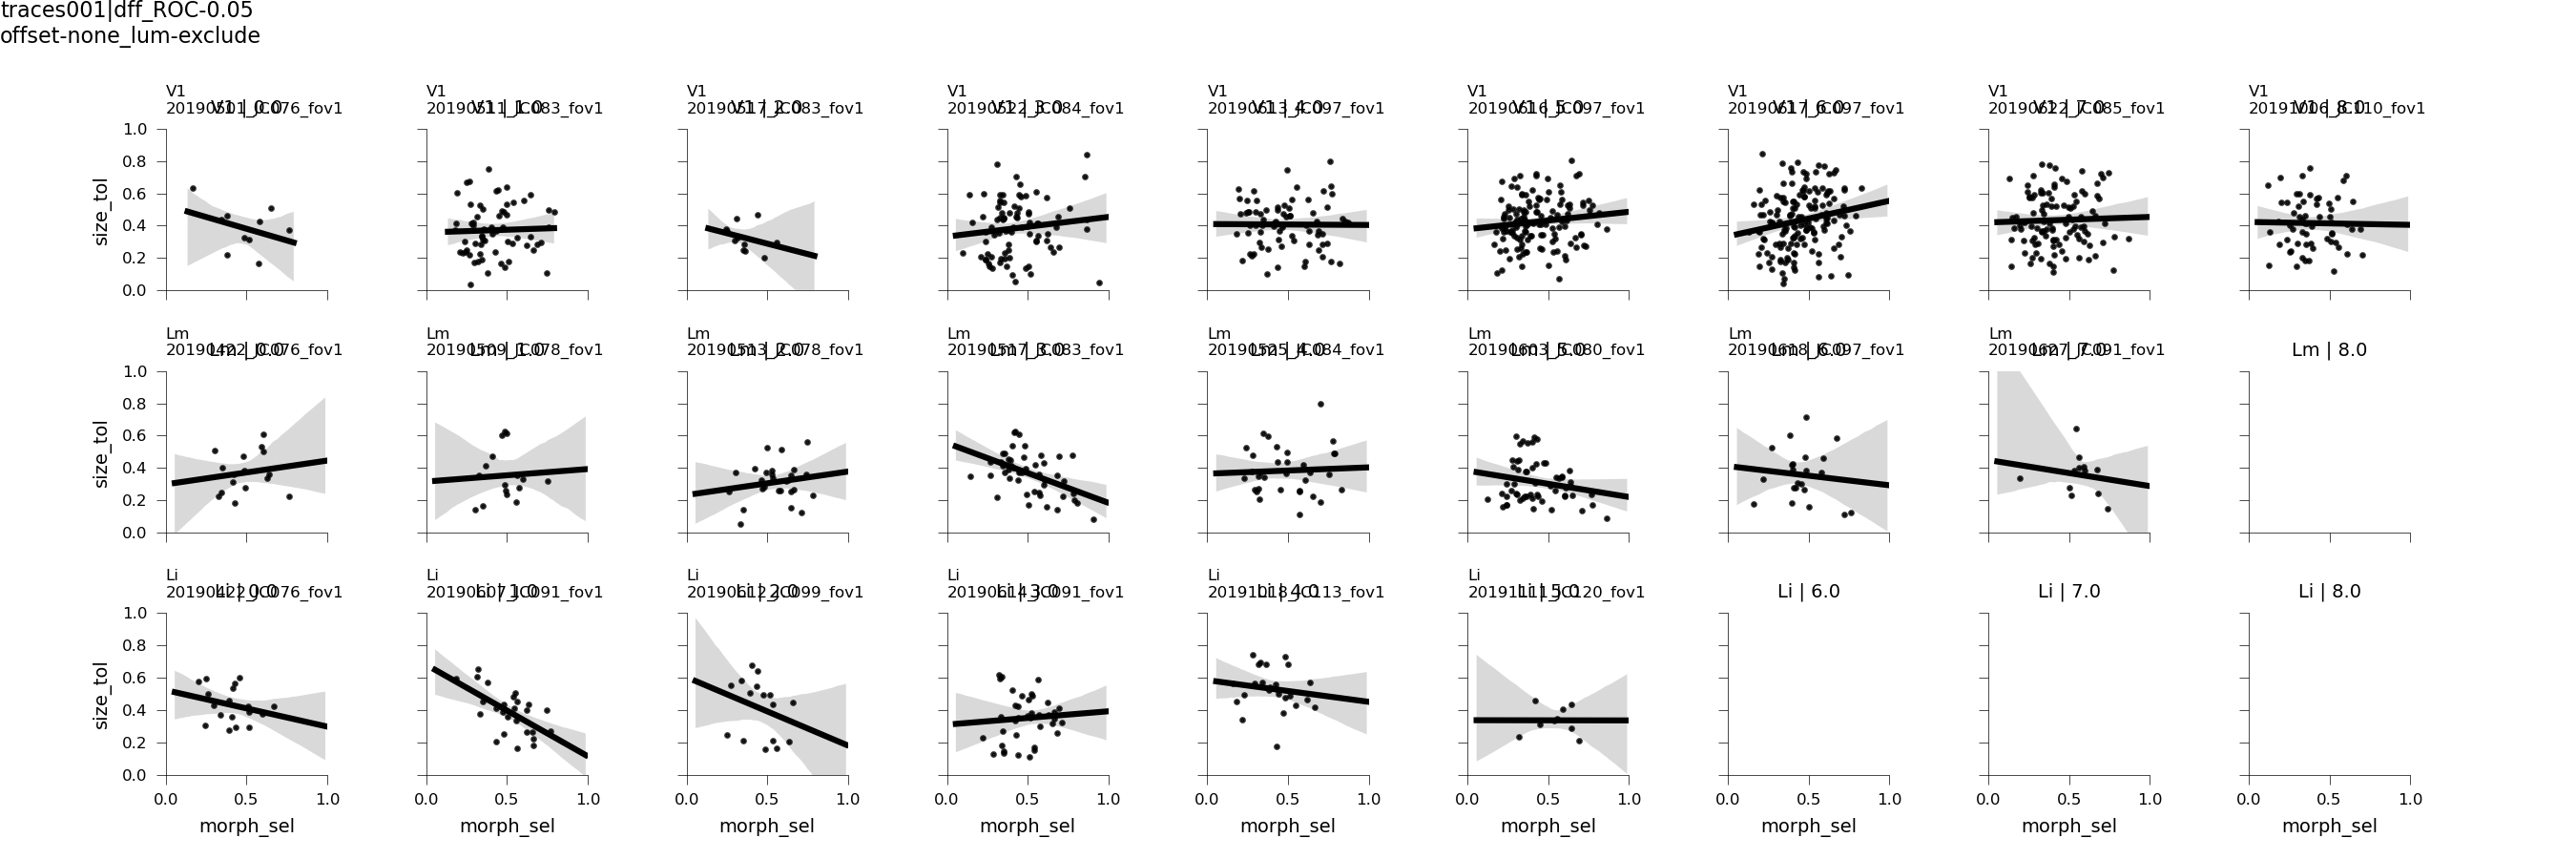

V1 0.0
V1 1.0
V1 2.0
V1 3.0
V1 4.0
V1 5.0
V1 6.0
V1 7.0
V1 8.0
Lm 0.0
Lm 1.0
Lm 2.0
Lm 3.0
Lm 4.0
Lm 5.0
Lm 6.0
Lm 7.0
Lm 8.0
Li 0.0
Li 1.0
Li 2.0
Li 3.0
Li 4.0
Li 5.0
Li 6.0
Li 7.0
Li 8.0
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus tradeoff_eachfov_ offset-none_lum-exclude


In [269]:
fg = sns.FacetGrid(col='site_num', row='visual_area', row_order=visual_areas,
                   data=DF, height=1.5)
fg.map(sns.regplot, 'morph_sel', 'size_tol',
            truncate=False, color='k', scatter_kws={'s':2})
# DF["group"] = DF["site_num"].map(dict((k, v) for k, v in DF[['site_num', 'datakey']].values))

for ax in fg.axes.flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
pl.subplots_adjust(top=0.85)
    
[pl.setp(ax.texts, text="") for ax in fg.axes.flat] # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    print(va, snum)
    dk = DF[(DF.visual_area==va) & (DF['site_num']==snum)]['datakey'].unique()
    if len(dk)==0:
        continue
    new_t = '%s\n%s' % (va, dk[0])
    ax.set_title(new_t, fontsize=6, loc='left')
pl.subplots_adjust(left=0.05, right=0.95, hspace=0.5)
fg.fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fg.fig, data_id)
figname = 'tradeoff_eachfov_ %s' % filter_str 

pl.savefig(os.path.join(dst_dir, '%s.png' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)

In [272]:
ixdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area').count()

datakey  cell
visual_area               
Li               132   132
Lm               233   233
V1               702   702

In [16]:
# # Get unique dkeys and count
u_dkeys = aggr.drop_repeats(n_cells_all)
min_ncells=10
if filter_rfs:
    NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
else:
    NDATA_all = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


In [17]:
NDATA_all[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

datakey  cell
visual_area               
Li               391   391
Lm               738   738
V1              1031  1031

In [20]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0, ignore_index=True)


In [21]:
NDATA_im[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area').count()

datakey  cell
visual_area               
Li               264   264
Lm               588   588
V1               991   991

## Count fraction lum-preferring

In [100]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [21]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_, NDATA_im)

<IPython.core.display.Javascript object>


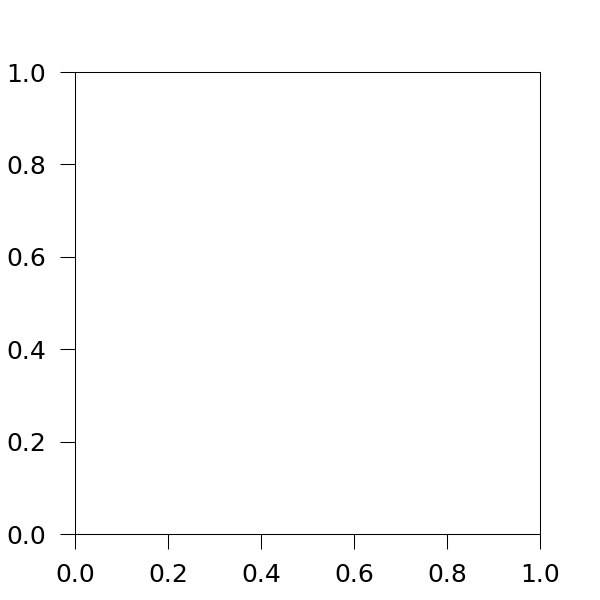

NameError: name 'cnt_each' is not defined

In [22]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


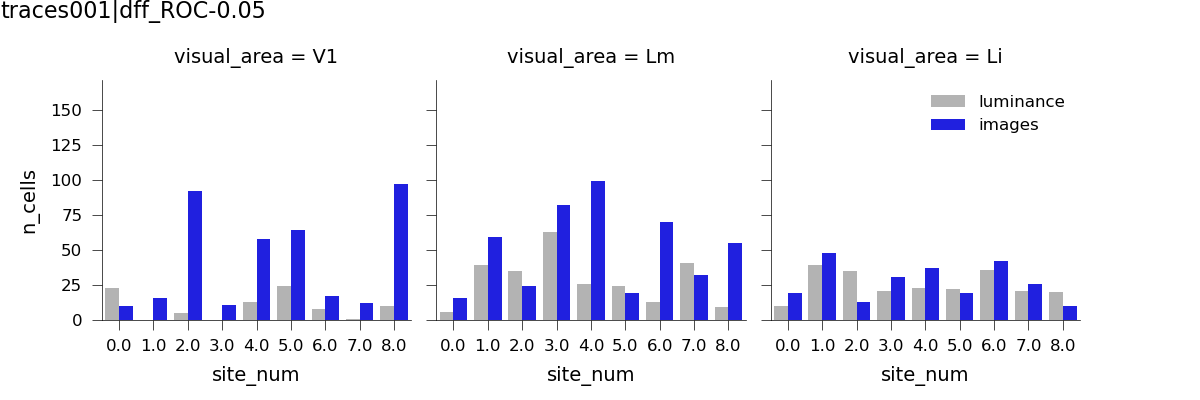

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [23]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [24]:
exclude_by_fraction=False
min_pref_lum = 0.5 if exclude_by_fraction else 1.0
if exclude_by_fraction:
    pref_obj = [(k, v) for k, v in \
                cnt_each[cnt_each['pref_luminance']<min_pref_lum]\
                [['visual_area', 'datakey']].values]
    NDATA1 = pd.concat([g for (va, dk), g in NDATA_im.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in pref_obj])
else:
    NDATA1 = NDATA_.copy()

In [25]:
NDATA1[['visual_area', 'datakey']].drop_duplicates().groupby('visual_area').count()

datakey
visual_area         
Li                 9
Lm                13
V1                14

In [26]:
curr_counts = NDATA1[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
u_dkeys = aggr.drop_repeats(n_cells_all)
NDATA_all = pd.concat([g for (va, dk), g in NDATA1.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


In [27]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_all.groupby(['visual_area', 'datakey']):
    sdf = aggr.get_stimuli(dk, experiment='blobs', match_names=True)
    im_df = sel.exclude_lum_is_best(ndf, sdf)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0) #, ignore_index=True)

In [28]:
totals, cnt_each = sel.count_fraction_luminance_preferring(NDATA_all, NDATA_im)

<IPython.core.display.Javascript object>


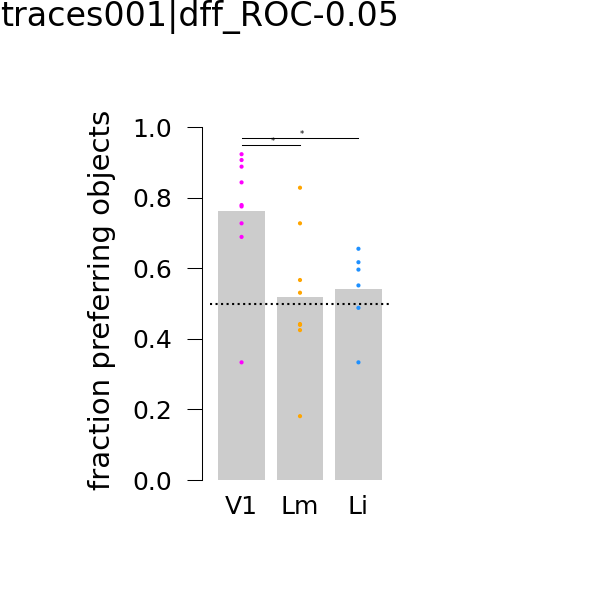

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


In [29]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
pplot.stripplot_metric_by_area(cnt_each, metric, area_colors=area_colors,ax=ax,
                            markersize=2, ylim=(0,1.02), 
                            sig_fontsize=2, jitter=False, 
                            plot_means=True, y_loc=0.95, offset=0.02,
                            mean_style='bar', mean_type='mean', aspect=2)
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('fraction preferring objects')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)
figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


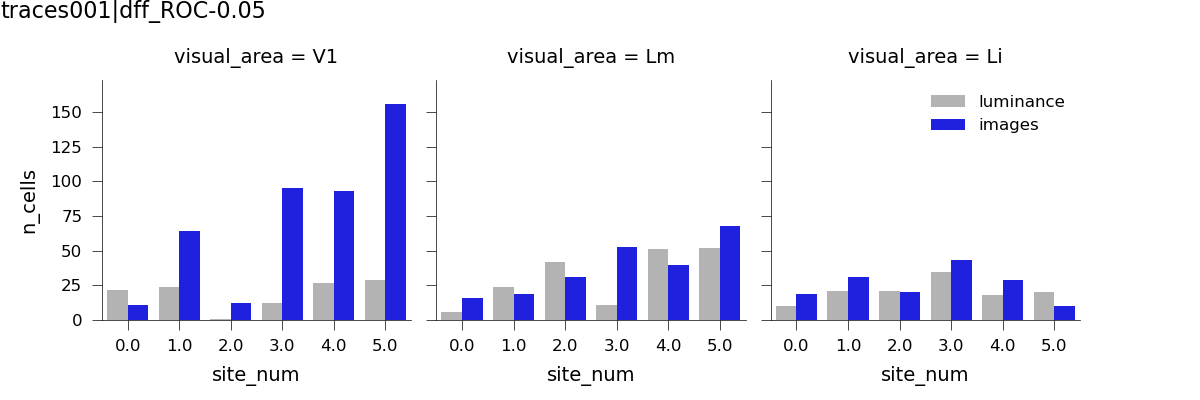

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [30]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=totals[totals.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
totals.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [31]:
NDATA_im[['visual_area', 'datakey']].drop_duplicates().groupby('visual_area').count()

datakey
visual_area         
Li                 6
Lm                 8
V1                 9

In [32]:
NDATA_all[['visual_area', 'datakey']].drop_duplicates().groupby('visual_area').count()

datakey
visual_area         
Li                 6
Lm                 8
V1                 9

# Aggregate metrics

In [63]:
# SDF, mislabeled = aggr.check_sdfs(meta['datakey'].unique(), experiment=experiment,
#                      images_only=False, rename=True, return_incorrect=True,
#                      return_all=True)

In [158]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [33]:
exclude=[] # wrong configs
offset_type = 'none' #'none'
lcorrection = 'exclude' #exclude' #'normalize' #'exclude' # 'exclude'
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)
print(filter_str)

filter_lum_pref=True

if filter_lum_pref:
    NDATA = NDATA_im.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
    data_struct = 'NDATA-im'
else:
    NDATA = NDATA_all.copy() #0.copy() # NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
    data_struct = 'NDATA-all'
    
#x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')

# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection, normalize=False)
print(ixdf['n_cells'].min())

offset-none_lum-exclude


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:614: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:614: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:614: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:614: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

10


In [34]:
ixdf[ixdf['size_tol']<0] = None
ixdf[ixdf['size_tol']>1] = None

ixdf[ixdf['morph_sel']<0] = None
ixdf[ixdf['morph_sel']>1] = None

In [35]:
# ixdf[ixdf['lum_size_pval']<0.05] = None
# ixdf[ixdf['lum_size_cc']>0.3] = None
# ixdf[ixdf['lum_size_cc']<-0.3] = None
ixdf[(ixdf['lum_size_pval']<0.05)
    & (ixdf['lum_size_cc']>=0.5)] = None

In [36]:
ixdf[(ixdf['lum_size_pval']<0.05)
    & (ixdf['lum_size_cc']>=0.5)].groupby('visual_area').count()

Empty DataFrame
Columns: [morph_sel, best_size, size_tol, best_morphlevel, size_tol_corr, best_morphlevel, sparseness_total, sparseness_morphs, sparseness_anchors, size_sel, lum_sel, lum_size_cc, lum_size_pval, cell, datakey, n_cells]
Index: []

In [37]:
# ixdf[(ixdf['lum_size_pval']<0.05)
#     & (ixdf['lum_size_cc']>0.5)] = None

<IPython.core.display.Javascript object>


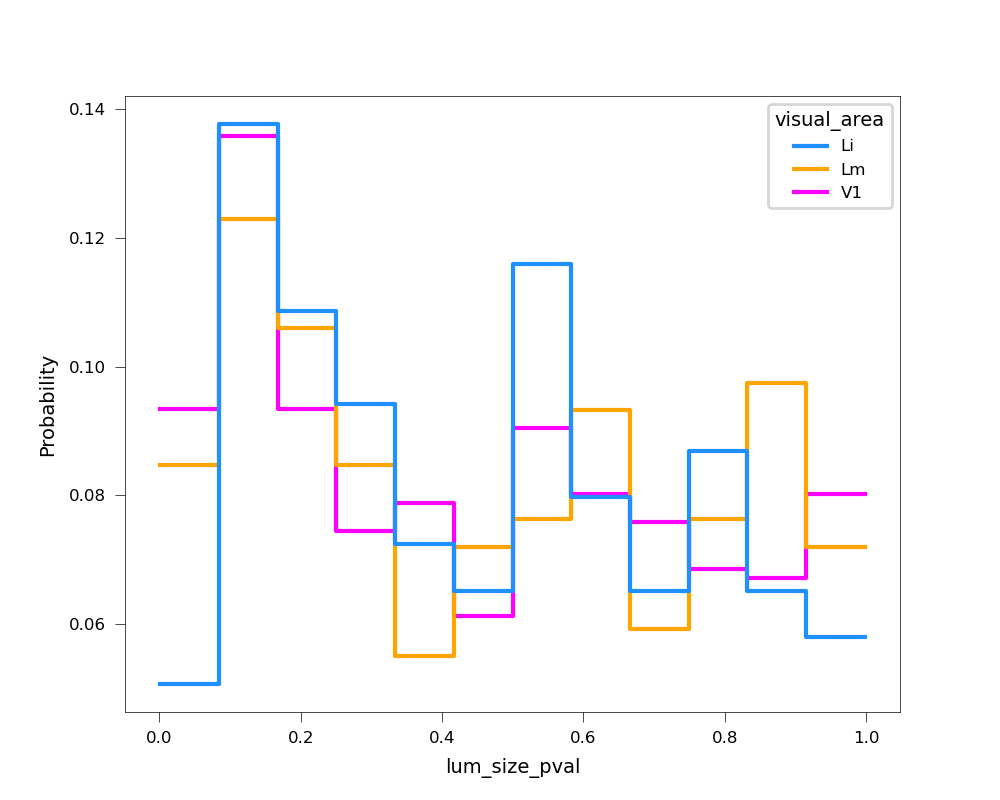

<AxesSubplot:xlabel='lum_size_pval', ylabel='Probability'>

In [38]:
fig, ax = pl.subplots()
sns.histplot(data=ixdf, hue='visual_area', x='lum_size_pval', ax=ax,
            palette=area_colors, stat='probability', common_norm=False,
             element='step', fill=False, cumulative=False)

<IPython.core.display.Javascript object>


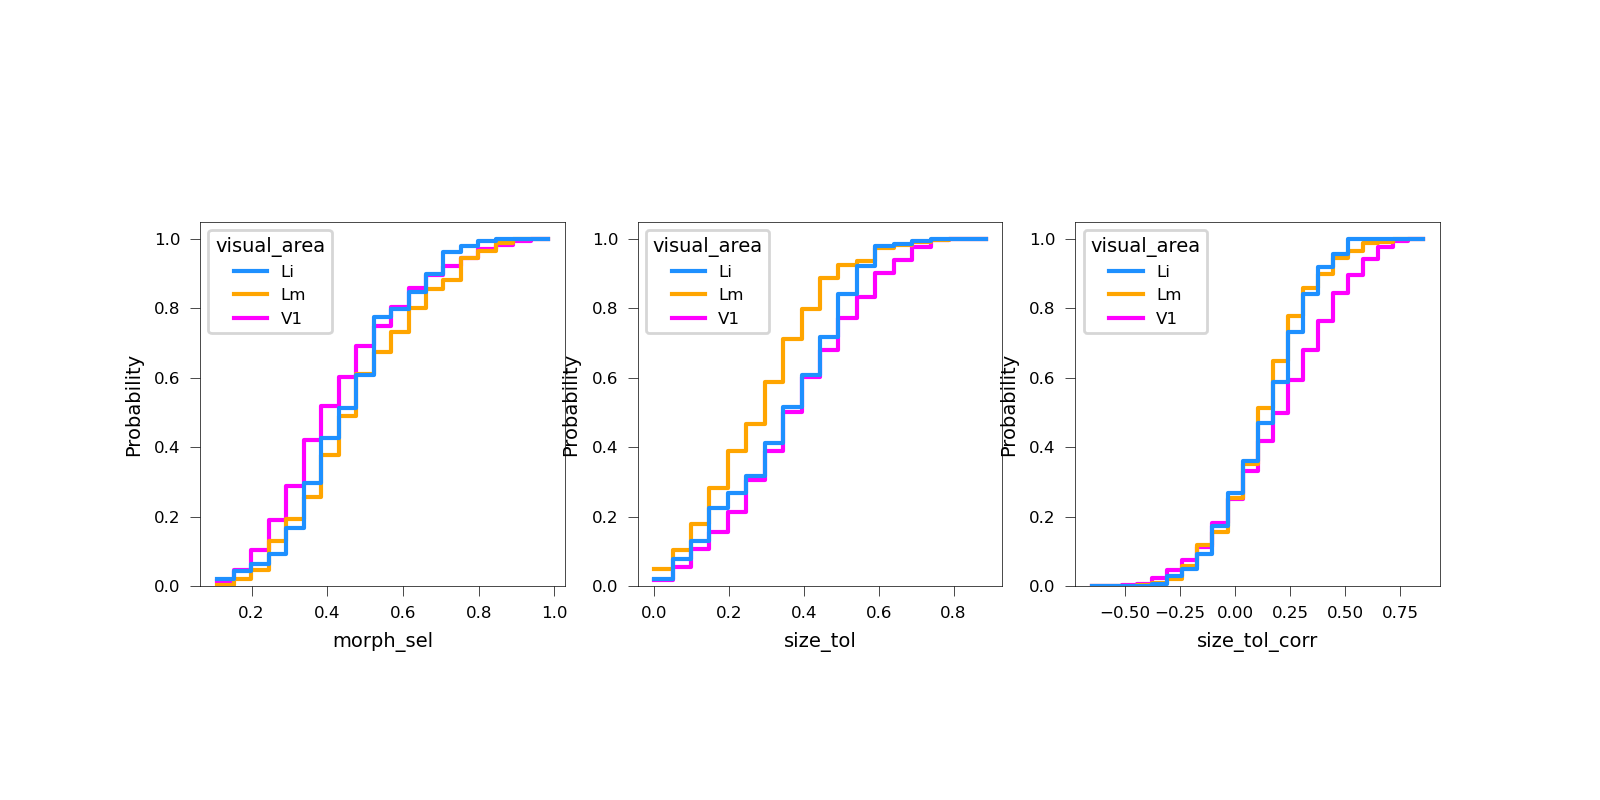

In [39]:
fig, axn = pl.subplots(1, 3, figsize=(8,4))
for ax, v in zip(axn, ['morph_sel', 'size_tol', 'size_tol_corr']):
    sns.histplot(data=ixdf, hue='visual_area', x=v, ax=ax,
            palette=area_colors, stat='probability', common_norm=False,
             element='step', fill=False, cumulative=True)
    ax.set_box_aspect(1)

In [40]:
import sys

In [41]:
dk = '20191018_JC113_fov1' # '20190616_JC097_fov1'
va = 'Li' #'V1'
x0 = NDATA[(NDATA['visual_area']==va) & (NDATA['datakey']==dk)].copy()
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
# rdf0[rdf0['cell']==cell]

/tmp/ipykernel_2284477/1164658622.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)


In [42]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [43]:
cell = 137 #317 #55 #273 #185.0
df = rdf0[rdf0['cell']==cell].copy()
df['response'] = df['response'].round(2) - df['response'].min() + 0.001 #2*abs(sys.float_info.epsilon)
df['size'] = [sdf['size'][c] for c in df['config']]
df['morphlevel'] = [sdf['morphlevel'][c] for c in df['config']]

df1 = sel.correct_luminance(df, sdf, lcorrection='normalize')

In [44]:
df

cell     config  response  size  morphlevel
1100   137  config001  0.025432  10.0          -1
1101   137  config002  0.035432  20.0          -1
1102   137  config003  0.015432  30.0          -1
1103   137  config004  0.045432  40.0          -1
1104   137  config005  0.015432  50.0          -1
1105   137  config006  0.035432  10.0           0
1106   137  config007  0.025432  20.0           0
1107   137  config008  0.035432  30.0           0
1108   137  config009  0.025432  40.0           0
1109   137  config010  0.035432  50.0           0
1110   137  config011  0.035432  10.0          14
1111   137  config012  0.035432  20.0          14
1112   137  config013  0.045432  30.0          14
1113   137  config014  0.035432  40.0          14
1114   137  config015  0.055432  50.0          14
1115   137  config016  0.015432  10.0          27
1116   137  config017  0.035432  20.0          27
1117   137  config018  0.035432  30.0          27
1118   137  config019  0.025432  40.0          27
1119   137  config020  0.035432  50.0          27
1120   137  config021  0.015432  10.0          40
1121   137  config022  0.035432  20.0          40
1122   137  config023  0.025432  30.0          40
1123   137  config024  0.015432  40.0          40
1124   137  config025  0.035432  50.0          40
1125   137  config026  0.035432  10.0          53
1126   137  config027  0.035432  20.0          53
1127   137  config028  0.035432  30.0          53
1128   137  config029  0.025432  40.0          53
1129   137  config030  0.025432  50.0          53
1130   137  config031  0.015432  10.0          66
1131   137  config032  0.035432  20.0          66
1132   137  config033  0.025432  30.0          66
1133   137  config034  0.015432  40.0          66
1134   137  config035  0.025432  50.0          66
1135   137  config036  0.045432  10.0          79
1136   137  config037  0.025432  20.0          79
1137   137  config038  0.025432  30.0          79
1138   137  config039  0.025432  40.0          79
1139   137  config040  0.015432  50.0          79
1140   137  config041  0.025432  10.0          92
1141   137  config042  0.035432  20.0          92
1142   137  config043  0.025432  30.0          92
1143   137  config044  0.025432  40.0          92
1144   137  config045  0.005432  50.0          92
1145   137  config046  0.015432  10.0         106
1146   137  config047  0.015432  20.0         106
1147   137  config048  0.005432  30.0         106
1148   137  config049  0.025432  40.0         106
1149   137  config050  0.025432  50.0         106

In [45]:
morph_tuning = sel.get_x_curves_at_best_y(df1[df1['morphlevel']!=-1], x='morphlevel', y='size',
                                normalize=False)
morph_tuning

cell     config  response  best_size  morphlevel
9    137  config010  1.296030       50.0           0
14   137  config015  2.592060       50.0          14
19   137  config020  1.296030       50.0          27
24   137  config025  1.296030       50.0          40
29   137  config030  0.648015       50.0          53
34   137  config035  0.648015       50.0          66
39   137  config040  0.000000       50.0          79
44   137  config045 -0.648015       50.0          92
49   137  config050  0.648015       50.0         106

<IPython.core.display.Javascript object>


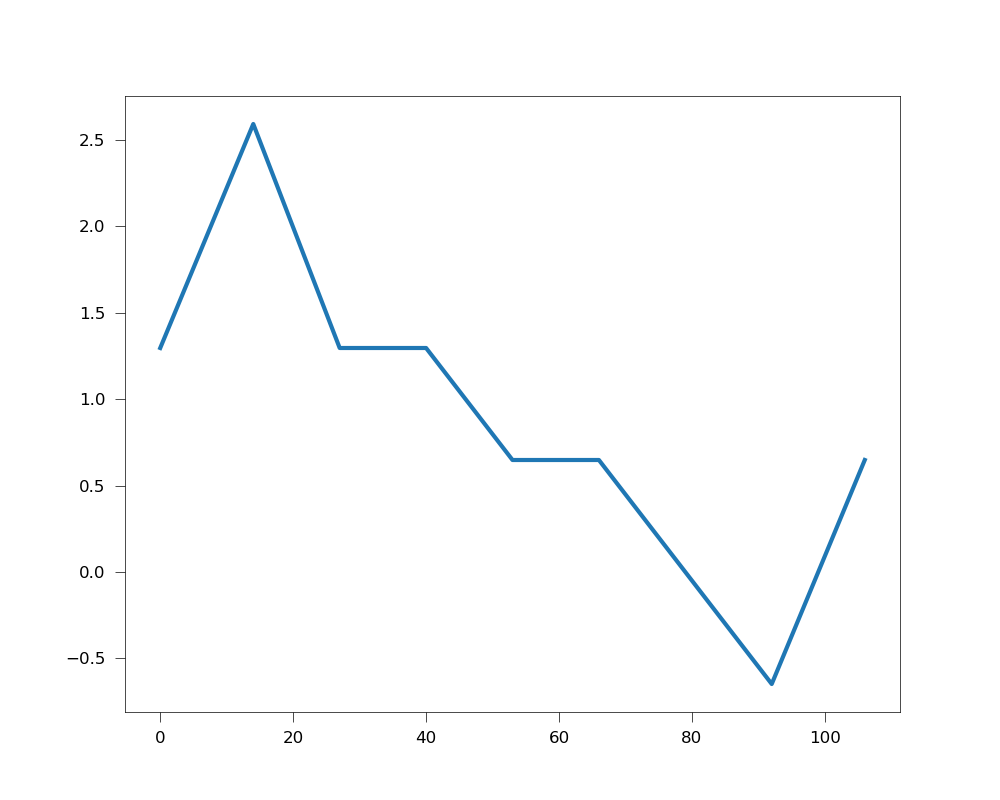

In [46]:
best_sz = morph_tuning['best_size'].iloc[0]
fig, ax = pl.subplots()
d_ = df1[ (df1['size']==best_sz) & (df1['morphlevel']!=-1)]
ax.plot(d_['morphlevel'], d_['response'])

<IPython.core.display.Javascript object>


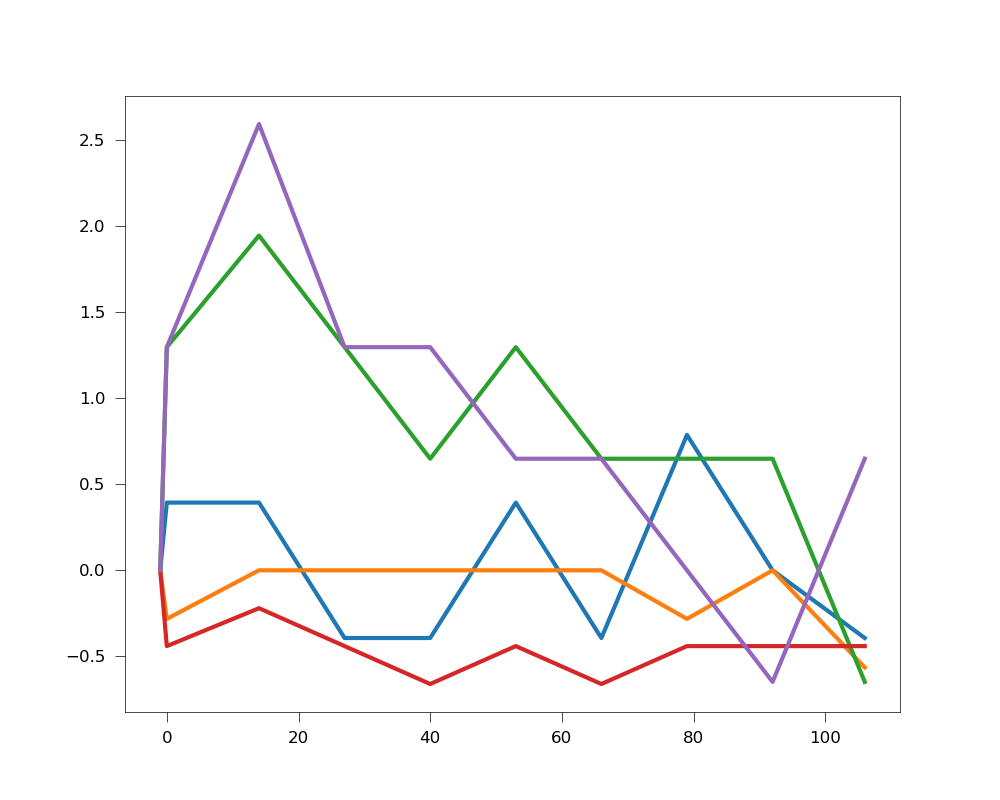

In [47]:
fig, ax = pl.subplots()
for sz in [10, 20, 30, 40, 50]: #sdf['size'].unique(): #[s for s in sdf['size'].unique() if s!=best_sz]: #[10, 30, 40, 50]:
    d_ = df1[ (df1['size']==sz) ] #& (df1['morphlevel']!=-1)]
    ax.plot(d_['morphlevel'], d_['response'])

In [48]:
# best_morph = morph_tuning['response']

# corrs = df1[df1['morphlevel']!=-1].groupby('size')\
#             .apply(lambda x: get_corr(x, morph_tuning))
# np.mean(corrs[corrs!=1])
sel.assign_size_tolerance(df1) #, morph_tuning)

size_tol  best_morphlevel
137  0.204195             14.0

In [49]:
size_resp_at_best_morph = sel.get_x_curves_at_best_y(df1, x='size', y='morphlevel',
                                normalize=False)
sel.size_tolerance(size_resp_at_best_morph['response'])

0.2041951169725157

In [50]:
size_resp_at_best_morph['response']

10    0.393209
11    0.000000
12    1.944045
13   -0.220110
14    2.592060
Name: response, dtype: float64

In [51]:
df_ = sel.get_x_curves_at_best_y(df1, x='size', y='morphlevel',
                                normalize=False)
df_

cell     config  response  size  best_morphlevel
10   137  config011  0.393209  10.0               14
11   137  config012  0.000000  20.0               14
12   137  config013  1.944045  30.0               14
13   137  config014 -0.220110  40.0               14
14   137  config015  2.592060  50.0               14

In [52]:
morph_ixs = df1[df1['morphlevel']!=-1].groupby(['cell'])\
                .apply(sel.assign_morph_ix, at_best_other=True, name='morph_sel')
# Calculate size tolerance (@ best morph)
size_tols = df1[df1['morphlevel']!=-1].groupby(['cell'])\
                .apply(sel.assign_size_tolerance, at_best_other=True, name='size_tol')
pd.concat([morph_ixs, size_tols], axis=1)

morph_sel  best_size  size_tol  best_morphlevel
cell                                                     
137  137       0.75       50.0  0.204195             14.0

<IPython.core.display.Javascript object>


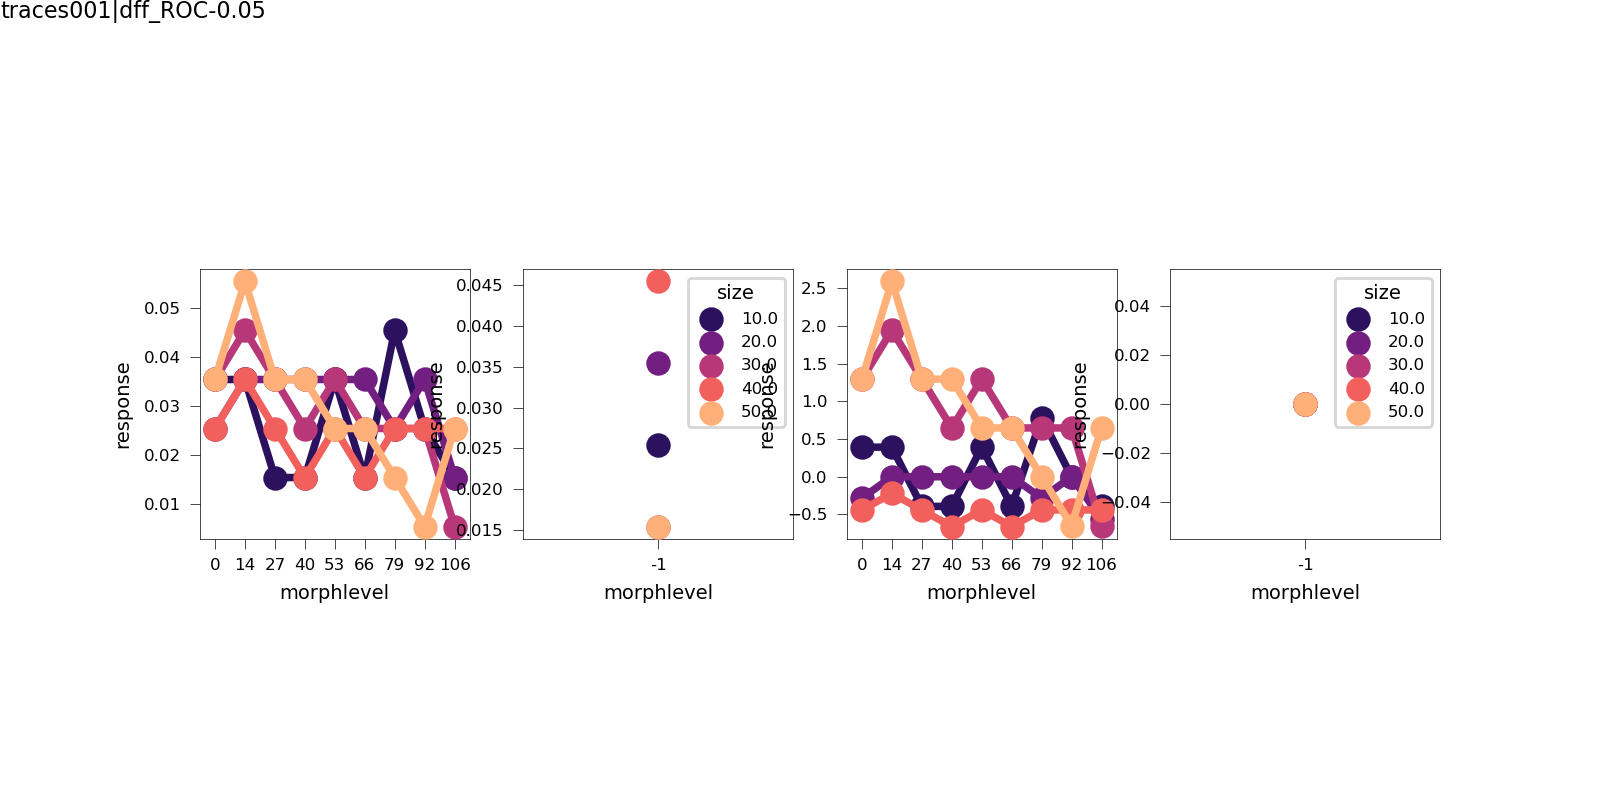

In [53]:
fig, axn = pl.subplots(1, 4, sharey=False, figsize=(8,4))
ax=axn[0]
sns.pointplot(data=df[df['morphlevel']!=-1], x='morphlevel', y='response', hue='size', 
              palette='magma', ax=ax)
ax.legend_.remove()
ax=axn[1]
sns.pointplot(data=df[df['morphlevel']==-1], x='morphlevel', y='response', hue='size', 
              palette='magma', ax=ax)
ax=axn[2]
sns.pointplot(data=df1[df1['morphlevel']!=-1], x='morphlevel', y='response', hue='size', 
              palette='magma', ax=ax)
ax.legend_.remove()
ax=axn[3]
sns.pointplot(data=df1[df1['morphlevel']==-1], x='morphlevel', y='response', hue='size', 
              palette='magma', ax=ax)
for ax in axn:
    ax.set_box_aspect(1)

In [54]:
(0.09-0.035)/0.035

1.5714285714285712

In [55]:
# Get mean value across trials 
mean_per_cell = NDATA.groupby(['visual_area', 'datakey', 'cell', 'config']).mean()\
                    .reset_index()
# len(mean_per_cell['config'].unique())

In [56]:
sdf_master = aggr.get_master_sdf(experiment='blobs', images_only=False)
mean_per_cell['size'] = [sdf_master.loc[cfg]['size'] \
                             for cfg in mean_per_cell['config'].values]
mean_per_cell['morphlevel'] = [sdf_master.loc[cfg]['morphlevel'] \
                             for cfg in mean_per_cell['config'].values]


In [57]:
mean_per_fov = mean_per_cell.groupby(\
                ['visual_area', 'datakey', 'config', 'size', 'morphlevel'])\
                .median().reset_index()
mean_per_fov

visual_area              datakey     config  size  morphlevel   cell  \
0             Li  20190422_JC076_fov1  config001  10.0          -1  277.0   
1             Li  20190422_JC076_fov1  config002  20.0          -1  277.0   
2             Li  20190422_JC076_fov1  config003  30.0          -1  277.0   
3             Li  20190422_JC076_fov1  config004  40.0          -1  277.0   
4             Li  20190422_JC076_fov1  config005  50.0          -1  277.0   
...          ...                  ...        ...   ...         ...    ...   
1145          V1  20191006_JC110_fov1  config046  10.0         106  219.0   
1146          V1  20191006_JC110_fov1  config047  20.0         106  219.0   
1147          V1  20191006_JC110_fov1  config048  30.0         106  219.0   
1148          V1  20191006_JC110_fov1  config049  40.0         106  219.0   
1149          V1  20191006_JC110_fov1  config050  50.0         106  219.0   

           trial  response  
0     751.133333  0.066819  
1     748.500000  0.035517  
2     752.033333  0.046387  
3     755.666667  0.039658  
4     749.300000  0.046106  
...          ...       ...  
1145  833.823529  0.057235  
1146  835.970588  0.068581  
1147  836.470588  0.043886  
1148  837.588235  0.035673  
1149  840.575758  0.029590  

[1150 rows x 8 columns]

<IPython.core.display.Javascript object>


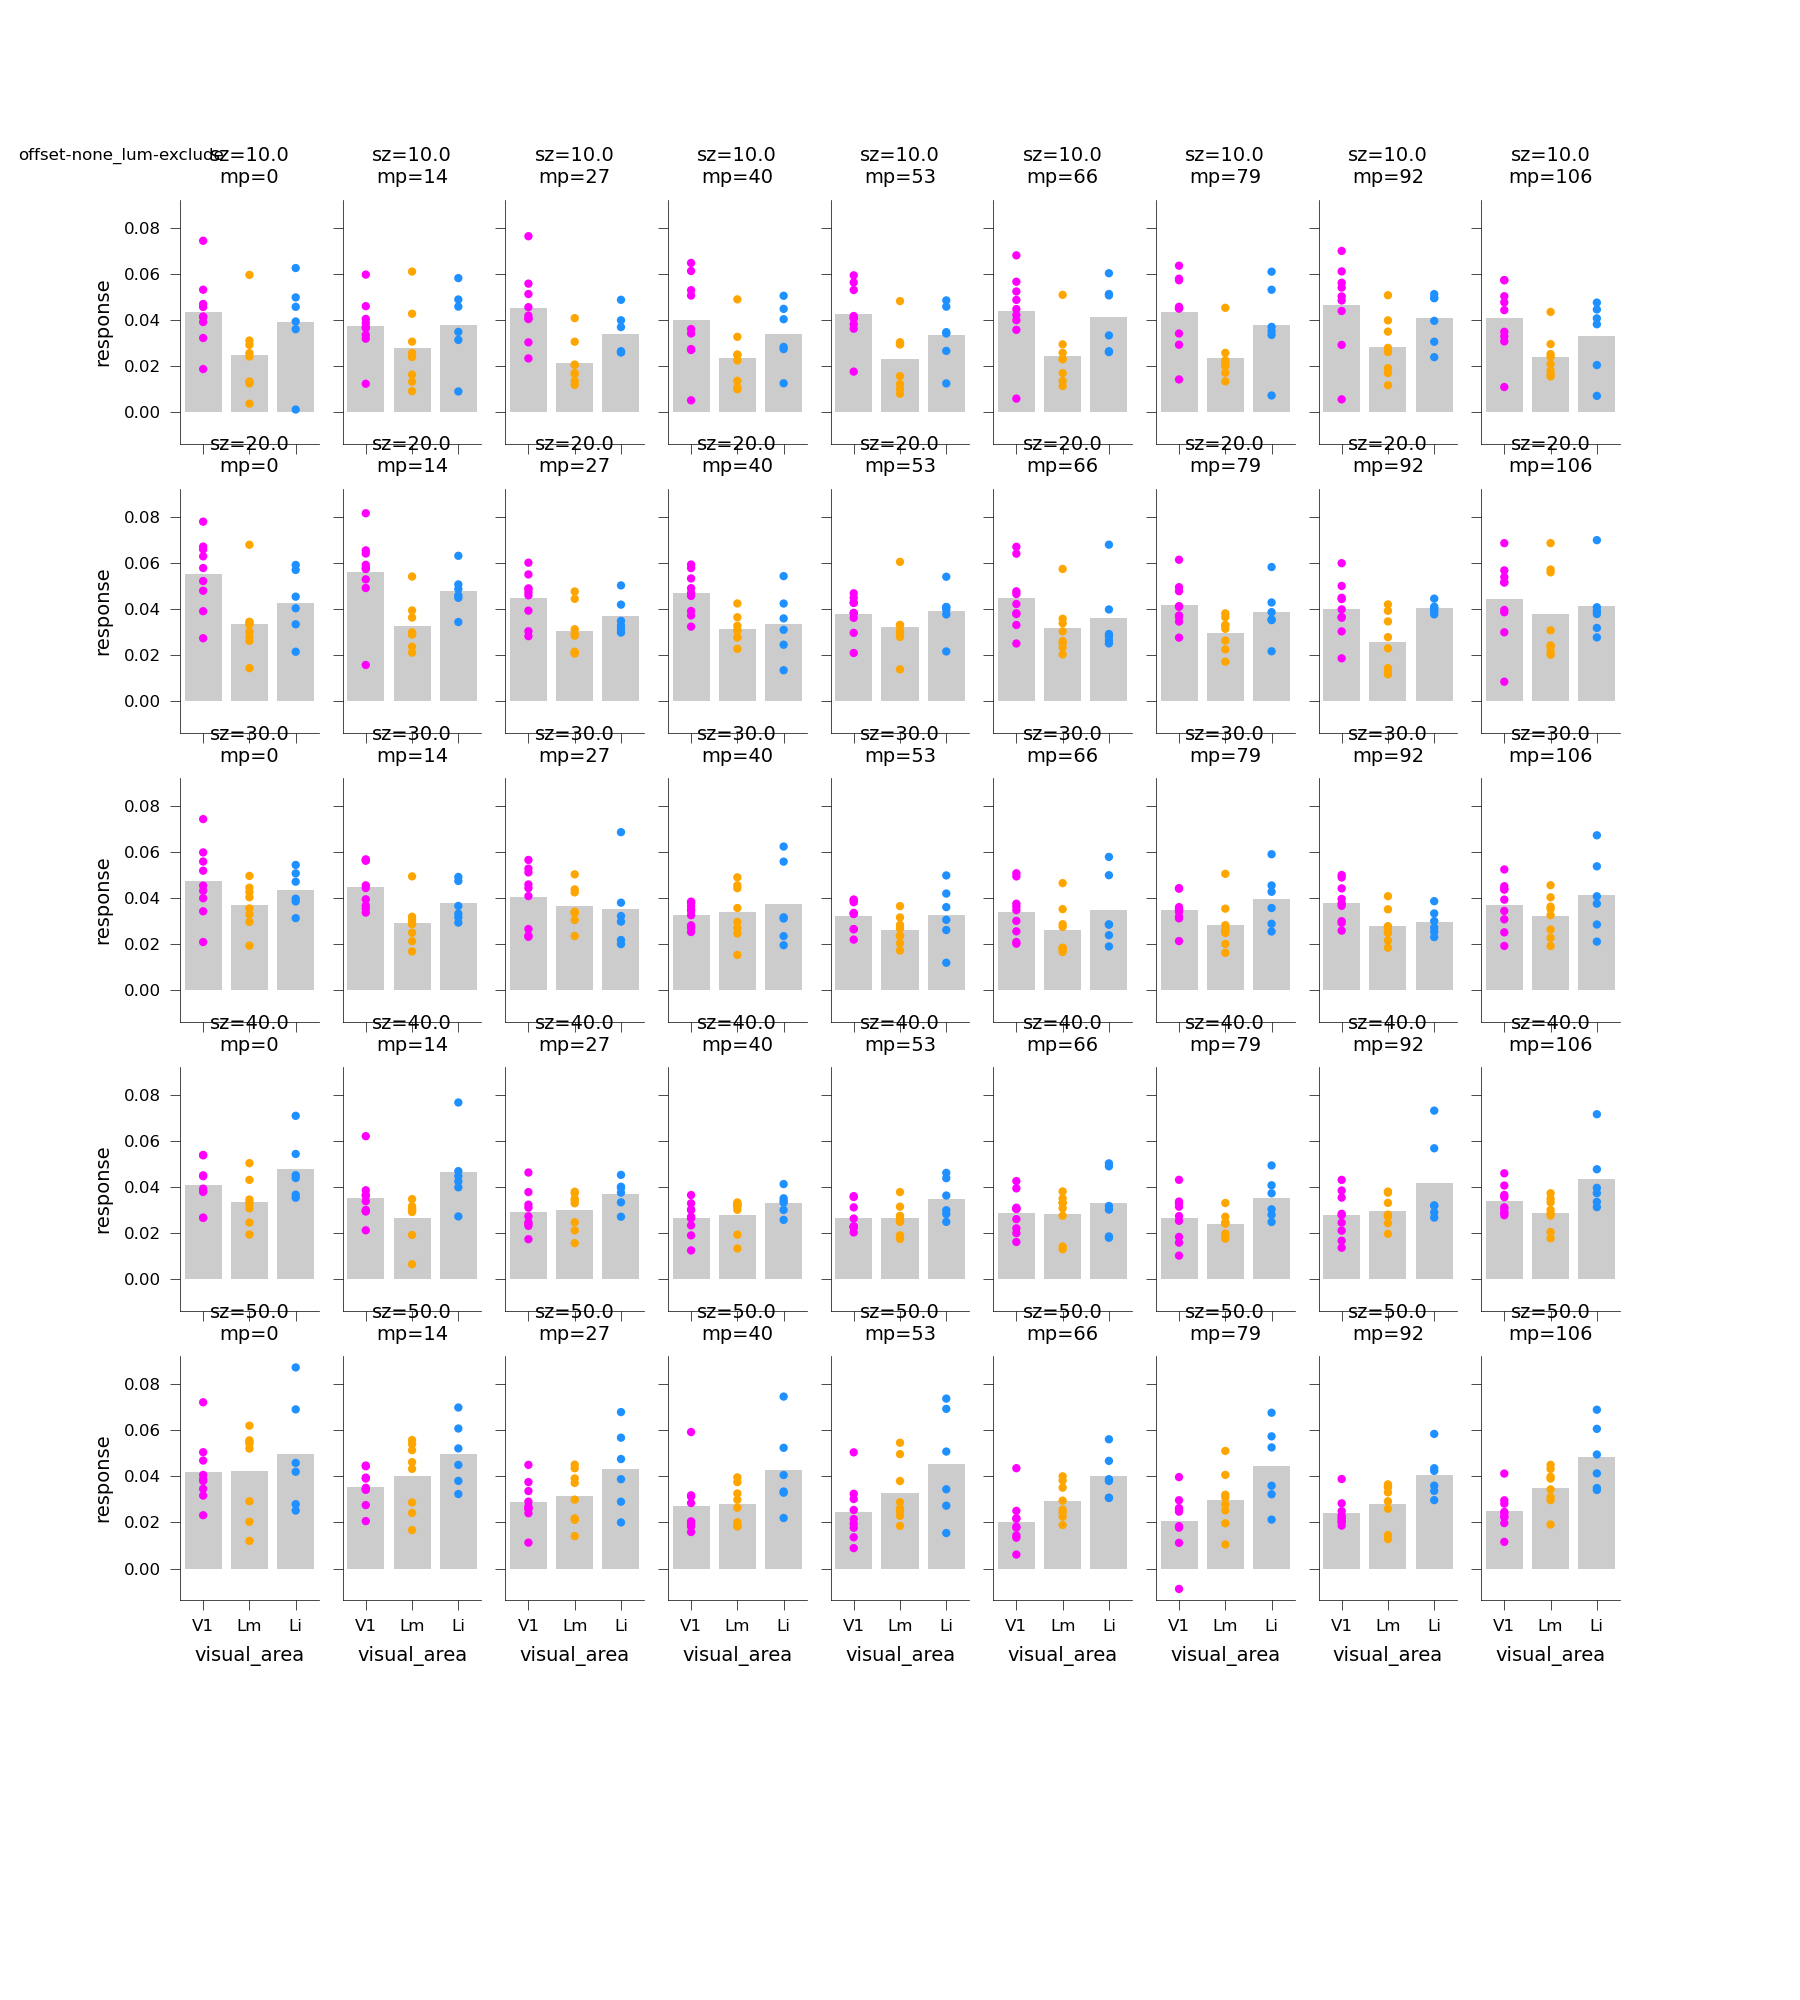

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

In [58]:
morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel!=-1].copy()
fg = sns.FacetGrid(data=morph_resp_fov, col='morphlevel', row='size', aspect=.5,
                   height=2)
fg.map(sns.barplot, 'visual_area', 'response',
      order=visual_areas, ci=None, color=[0.8]*3)
fg.map(sns.stripplot, 'visual_area', 'response', 'visual_area',
      order=visual_areas, palette=area_colors, size=3, jitter=False,
       hue_order=visual_areas)
fg.set_titles("sz={row_name}\nmp={col_name}")
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
fg.fig.text(0.01, 0.92, filter_str)

pplot.label_figure(fig, data_id)
figname ='avg_response_per_cond_%s_%s' % (data_struct, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


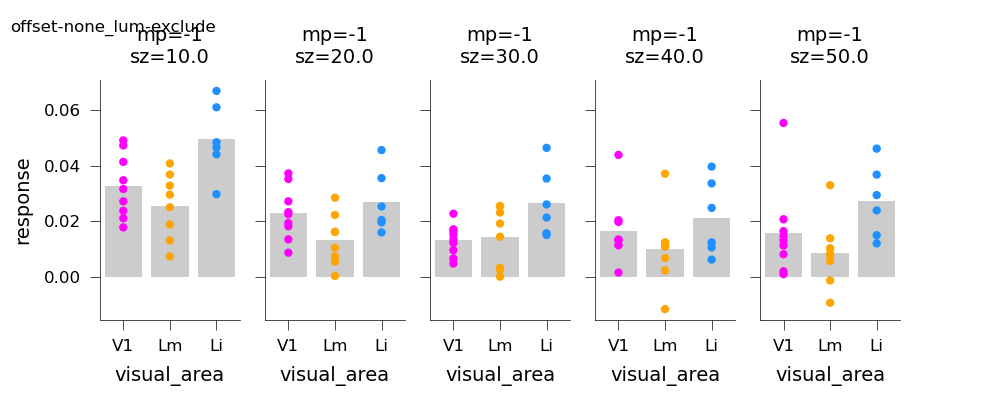

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

In [60]:
morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel==-1].copy()
fg = sns.FacetGrid(data=morph_resp_fov, col='size', row='morphlevel', aspect=.5,
                   height=2)
fg.map(sns.barplot, 'visual_area', 'response',
      order=visual_areas, ci=None, color=[0.8]*3)
fg.map(sns.stripplot, 'visual_area', 'response', 'visual_area',
      order=visual_areas, palette=area_colors, size=3, jitter=False,
       hue_order=visual_areas)
fg.set_titles("mp={row_name}\nsz={col_name}")

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.92, filter_str)

figname ='size_responses_to_morph-1_LUM_%s_%s' % (data_struct, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [61]:
morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel!=-1].copy()
morph_resp_across_size = morph_resp_fov.groupby(\
                            ['visual_area', 'datakey', 'morphlevel']).mean().reset_index()
morph_resp_across_size

/tmp/ipykernel_1739102/3622995667.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  morph_resp_across_size = morph_resp_fov.groupby(\


visual_area              datakey  morphlevel  size   cell       trial  \
0            Li  20190422_JC076_fov1           0  30.0  277.0  749.053333   
1            Li  20190422_JC076_fov1          14  30.0  277.0  750.546667   
2            Li  20190422_JC076_fov1          27  30.0  277.0  748.800000   
3            Li  20190422_JC076_fov1          40  30.0  277.0  750.726667   
4            Li  20190422_JC076_fov1          53  30.0  277.0  750.700000   
..          ...                  ...         ...   ...    ...         ...   
202          V1  20191006_JC110_fov1          53  30.0  219.0  835.467558   
203          V1  20191006_JC110_fov1          66  30.0  219.0  843.031729   
204          V1  20191006_JC110_fov1          79  30.0  219.0  839.642424   
205          V1  20191006_JC110_fov1          92  30.0  219.0  837.104635   
206          V1  20191006_JC110_fov1         106  30.0  219.0  836.885740   

     response  
0    0.046735  
1    0.053909  
2    0.052830  
3    0.047153  
4    0.049321  
..        ...  
202  0.039135  
203  0.040152  
204  0.043351  
205  0.042609  
206  0.046993  

[207 rows x 7 columns]

<IPython.core.display.Javascript object>


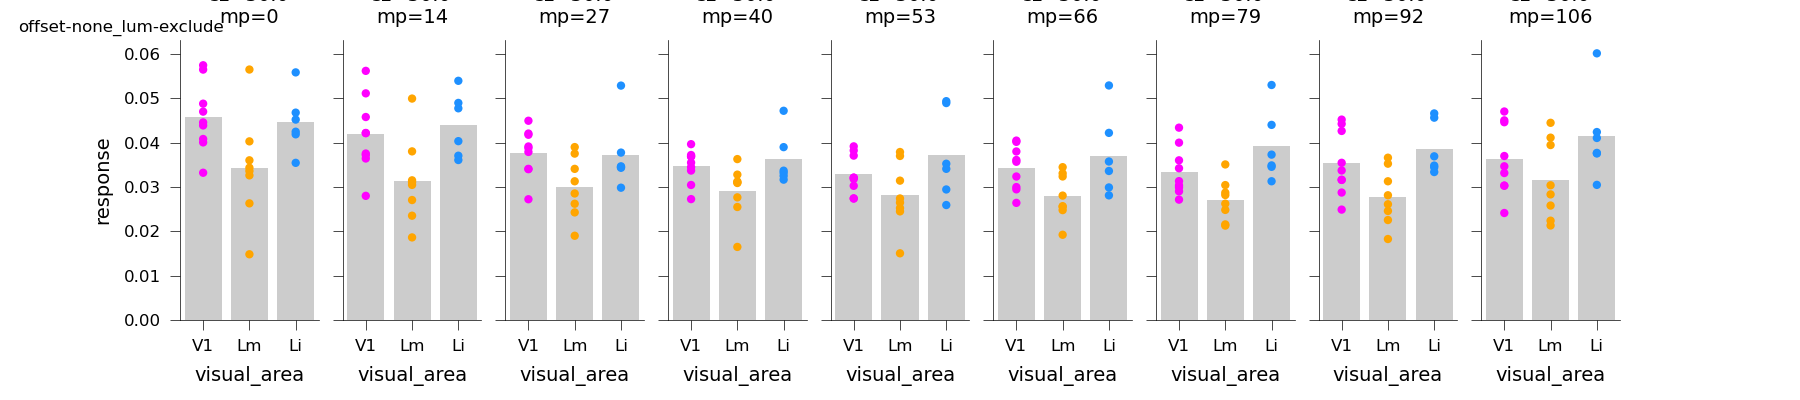

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/n/h

In [62]:
#morph_resp_fov = mean_per_fov[mean_per_fov.morphlevel!=-1].copy()
fg = sns.FacetGrid(data=morph_resp_across_size, col='morphlevel', row='size', aspect=.5,
                   height=2)
fg.map(sns.barplot, 'visual_area', 'response',
      order=visual_areas, ci=None, color=[0.8]*3)
fg.map(sns.stripplot, 'visual_area', 'response', 'visual_area',
      order=visual_areas, palette=area_colors, size=3, jitter=False,
       hue_order=visual_areas)
fg.set_titles("sz={row_name}\nmp={col_name}")

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)
fg.fig.text(0.01, 0.92, filter_str)

figname ='morph_responses_avg-across-size_%s_%s' % (data_struct,  filter_str)
figname ='avg_response_per_cond_LUM_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate selectivity metrics

In [42]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-plushalf'

In [43]:
min_ncells=10

print(ixdf.shape)
lum_cols = [k for k in ixdf.columns if 'lum' in k]
if lcorrection=='normalize':
    for k in lum_cols:
        ixdf = ixdf.drop(k, 1)
for va, vg in ixdf.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    ixdf.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]
DF = ixdf[ixdf['n_cells']>=min_ncells].copy().dropna()
print(ixdf.shape, ixdf.dropna().shape, DF.shape)

(1220, 17)
(1220, 18) (1059, 18) (1059, 18)


In [44]:
print('size_tol', ixdf[(ixdf['size_tol']>1) | (ixdf['size_tol']<0)].shape)
print('morph_sel', ixdf[(ixdf['morph_sel']>1) | (ixdf['morph_sel']<0)].shape)
print('sparseness_morphs', ixdf[(ixdf['sparseness_morphs']>1) | (ixdf['sparseness_morphs']<0)].shape)

size_tol (0, 18)
morph_sel (0, 18)
sparseness_morphs (0, 18)


In [45]:
# Get means by FOV
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

## By fov metrics

In [46]:
importlib.reload(pplot)
import analyze2p.stats as sts

[mean]:
  visual_area  sparseness_morphs  sparseness_total  morph_sel  size_tol  \
0          Li           0.190730          0.184801   0.477022  0.390008   
1          Lm           0.227780          0.224268   0.494908  0.323729   
2          V1           0.221368          0.221675   0.417706  0.383956   

   size_tol_corr  sparseness_morphs_std  sparseness_total_std  morph_sel_std  \
0       0.199120               0.023789              0.019243       0.055809   
1       0.175670               0.025311              0.025536       0.058773   
2       0.233692               0.018694              0.027544       0.051956   

   size_tol_std  size_tol_corr_std  
0      0.064664           0.107872  
1      0.054983           0.051399  
2      0.028411           0.069016  


<IPython.core.display.Javascript object>


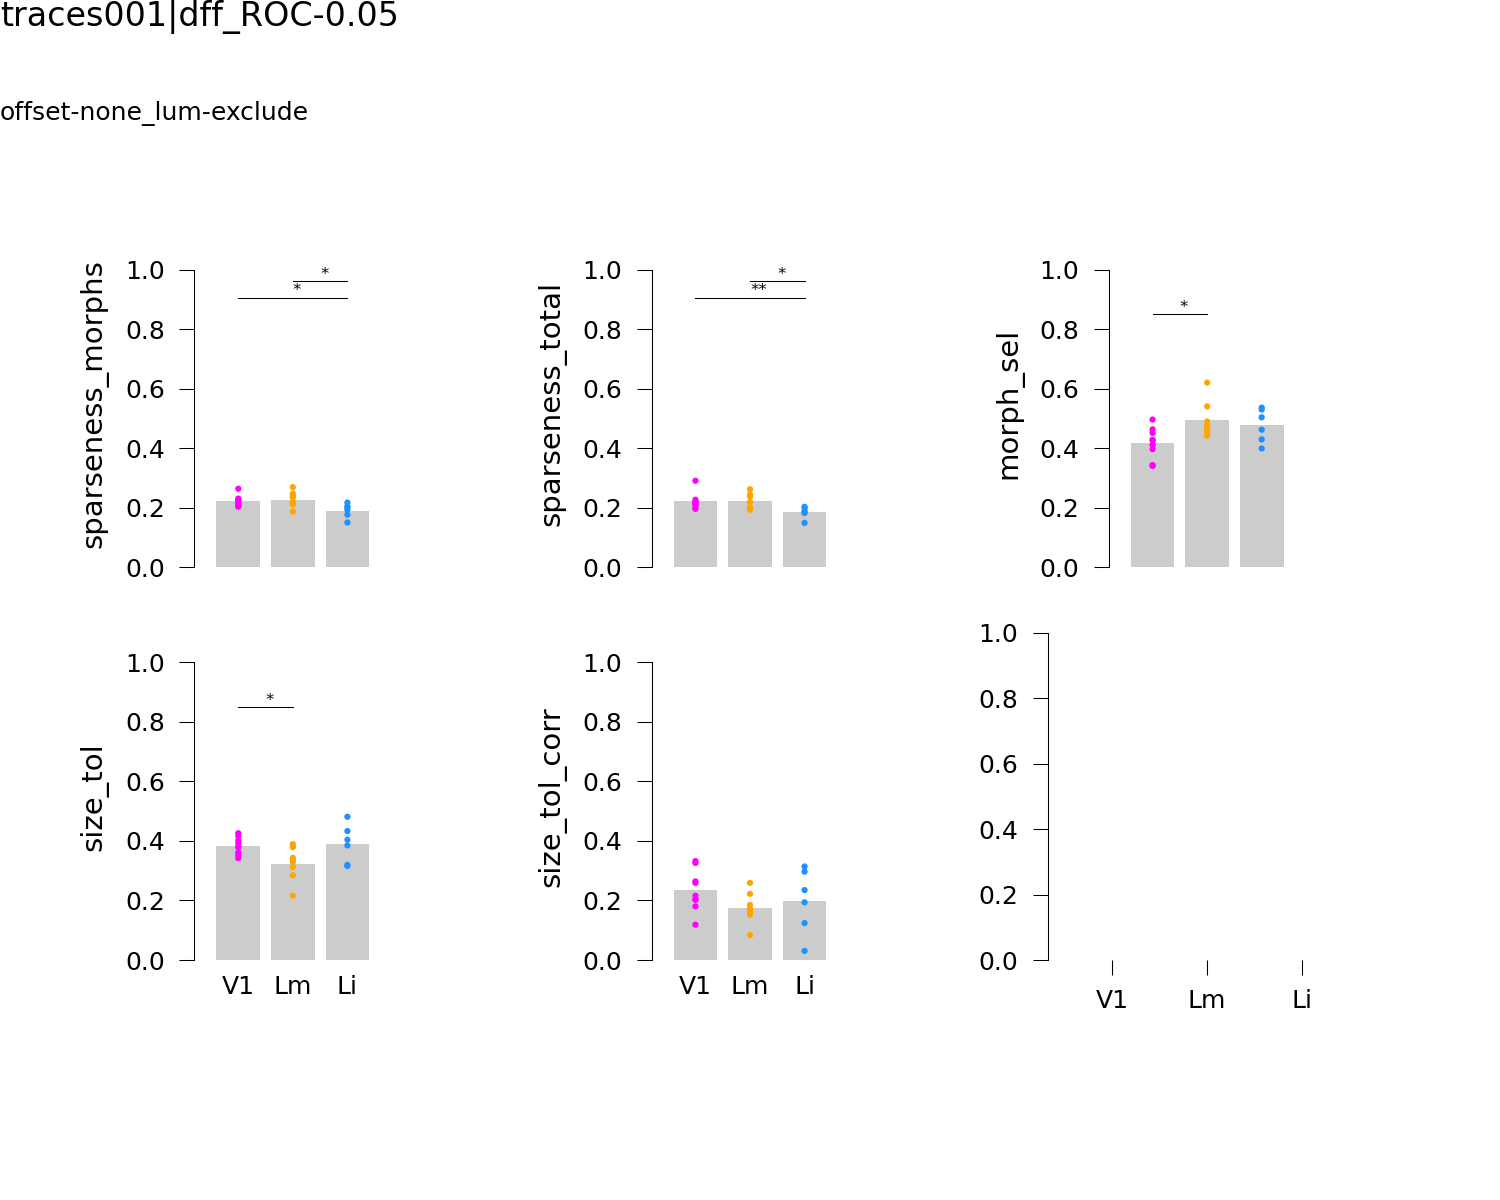

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None`

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-plushalf metrics_byFOV_NDATA-im_offset-none_lum-exclude
sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.19  0.02  0.15  0.18  0.20  0.20  0.22
Lm             8.0  0.23  0.03  0.19  0.21  0.23  0.24  0.27
V1             9.0  0.22  0.02  0.20  0.21  0.22  0.23  0.26
sparseness_total ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             6.0  0.18  0.02  0.15  0.18  0.19  0.20  0.20
Lm             8.0  0.22  0.03  0.19  0.20  0.23  0.24  0.26
V1             9.0  0.22  0.03  0.20  0.21  0.22  0.22  0.29
morph_sel ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                    

In [47]:
%matplotlib notebook
plot_params=['sparseness_morphs', 'sparseness_total', 'morph_sel', 
             'size_tol', 'size_tol_corr']#, 
             #'lum_sel', 'lum_size_cc', , ]

mean_type='mean'
multi_comp_test='fdr_bh' #'fdr_bh'
stat = 'mannwhitney'

markersize = 3
fw=5
ymax=0.8 + 0.04
plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(2, int(np.ceil(len(plot_params)/2)), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.1
    y_loc = np.ceil(plotdf[metric].max())*0.85
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                stat=stat, posthoc=multi_comp_test,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='bar', mean_type=mean_type, aspect=2)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.6)
sns.despine(offset=4, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byFOV_%s_%s' % (data_struct, filter_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))


In [223]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus'

In [224]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

[median]:
  visual_area  sparseness_morphs  sparseness_total  morph_sel  size_tol  \
0          Li           0.188789          0.184809   0.472386  0.406819   
1          Lm           0.213211          0.208620   0.444174  0.348674   
2          V1           0.214680          0.213207   0.411184  0.404749   

   size_tol_corr  sparseness_morphs_std  sparseness_total_std  morph_sel_std  \
0       0.195901               0.082382              0.078856       0.153532   
1       0.149207               0.096883              0.091275       0.169763   
2       0.213504               0.098173              0.094204       0.173808   

   size_tol_std  size_tol_corr_std  
0      0.176688           0.252069  
1      0.160337           0.212341  
2      0.178271           0.258688  


<IPython.core.display.Javascript object>


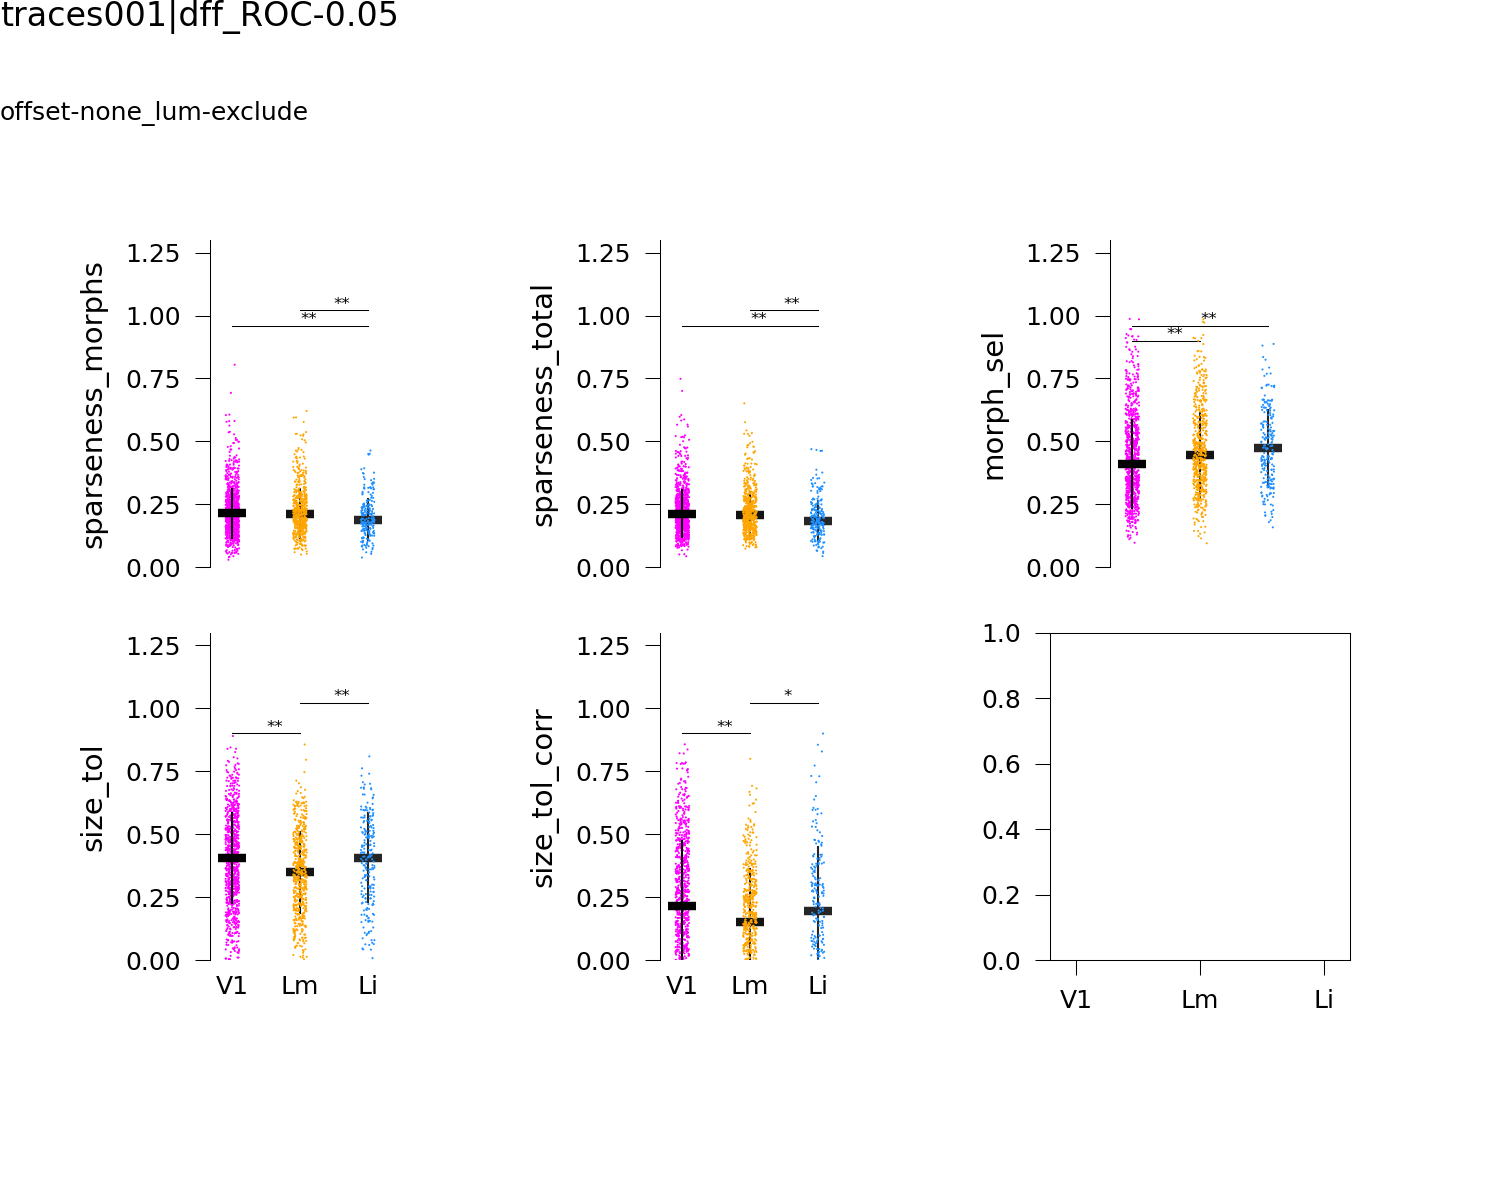

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:906: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  markers='_', errwidth=errwidth, ci='sd') #zorder=10000,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/pyt

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus metrics_byCELL_NDATA-im_offset-none_lum-exclude_2


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:906: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  markers='_', errwidth=errwidth, ci='sd') #zorder=10000,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/pyt

In [37]:
%matplotlib notebook
mean_type = 'median'
multi_comp_test='fdr_bh' #'fdr_bh'

fw=5
markersize = 1 

plotdf = DF.copy() #dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(2, int(np.ceil(len(plot_params)/2)), figsize=(fw, 4), 
                       sharex=True, sharey=False, dpi=150)
for ai, metric in enumerate(plot_params):
    ax=axn.flat[ai]
    ymax = np.ceil(plotdf[metric].max())*1.3
    y_loc = np.ceil(plotdf[metric].max())*0.9
    ylim = (-ymax,ymax) if metric=='lum_size_cc' else (0, ymax)
    pplot.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_style='point', mean_type=mean_type)
    #ax.legend_.remove()
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'metrics_byCELL_%s_%s_2' % (data_struct, filter_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [38]:

for par in plot_params:
    print("%s ------------------------" % par)
    print(plotdf.groupby('visual_area')[par].describe().round(2))


sparseness_morphs ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li           215.0  0.20  0.08  0.04  0.15  0.19  0.24  0.46
Lm           553.0  0.23  0.10  0.05  0.17  0.21  0.28  0.62
V1           884.0  0.23  0.10  0.03  0.16  0.21  0.28  0.80
sparseness_total ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li           215.0  0.20  0.08  0.04  0.15  0.18  0.23  0.47
Lm           553.0  0.23  0.09  0.07  0.16  0.21  0.27  0.65
V1           884.0  0.23  0.09  0.04  0.16  0.21  0.27  0.75
morph_sel ------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li           215.0  0.48  0.15  0.16  0.35  0.47  0.59  0.89
Lm           553.0  0.47  0.17  0.10  0.35  0.44  0.58  0.99
V1           884.0  0.44  

In [227]:
DF.groupby(['visual_area', 'datakey']).count()

morph_sel  best_size  size_tol  \
visual_area datakey                                               
Li          20190422_JC076_fov1         19         19        19   
            20190607_JC091_fov1         31         31        31   
            20190612_JC099_fov1         19         19        19   
            20190614_JC091_fov1         43         43        43   
            20191018_JC113_fov1         29         29        29   
            20191105_JC117_fov1         52         52        52   
            20191111_JC120_fov1         10         10        10   
Lm          20190422_JC076_fov1         16         16        16   
            20190509_JC078_fov1         19         19        19   
            20190513_JC078_fov1         31         31        31   
            20190517_JC083_fov1         52         52        52   
            20190525_JC084_fov1         40         40        40   
            20190603_JC080_fov1         68         68        68   
            20190618_JC097_fov1         24         24        24   
            20190627_JC091_fov1         17         17        17   
V1          20190501_JC076_fov1         11         11        11   
            20190511_JC083_fov1         64         64        64   
            20190517_JC083_fov1         12         12        12   
            20190522_JC084_fov1         95         95        95   
            20190613_JC097_fov1         93         93        93   
            20190616_JC097_fov1        155        155       155   
            20190617_JC097_fov1        161        161       161   
            20190622_JC085_fov1        135        135       135   
            20191006_JC110_fov1         67         67        67   

                                 best_morphlevel  size_tol_corr  \
visual_area datakey                                               
Li          20190422_JC076_fov1               19             19   
            20190607_JC091_fov1               31             31   
            20190612_JC099_fov1               19             19   
            20190614_JC091_fov1               43             43   
            20191018_JC113_fov1               29             29   
            20191105_JC117_fov1               52             52   
            20191111_JC120_fov1               10             10   
Lm          20190422_JC076_fov1               16             16   
            20190509_JC078_fov1               19             19   
            20190513_JC078_fov1               31             31   
            20190517_JC083_fov1               52             52   
            20190525_JC084_fov1               40             40   
            20190603_JC080_fov1               68             68   
            20190618_JC097_fov1               24             24   
            20190627_JC091_fov1               17             17   
V1          20190501_JC076_fov1               11             11   
            20190511_JC083_fov1               64             64   
            20190517_JC083_fov1               12             12   
            20190522_JC084_fov1               95             95   
            20190613_JC097_fov1               93             93   
            20190616_JC097_fov1              155            155   
            20190617_JC097_fov1              161            161   
            20190622_JC085_fov1              135            135   
            20191006_JC110_fov1               67             67   

                                 best_morphlevel  sparseness_total  \
visual_area datakey                                                  
Li          20190422_JC076_fov1               19                19   
            20190607_JC091_fov1               31                31   
            20190612_JC099_fov1               19                19   
            20190614_JC091_fov1               43                43   
            20191018_JC113_fov1               29                29   
            20191105_JC117_fov1               52         

In [200]:
## subsample and recalculate

In [201]:
n_sites = DF[['visual_area', 'datakey']].drop_duplicates().shape
n_samples = 50
n_iters = 1000
s_ = []
for i in range(n_iters):
    subdf = DF.groupby(['visual_area']).sample(n=n_samples, 
                                                  replace=False) #, random_state=5)
    samp_mean = subdf.groupby(['visual_area'])[plot_params].mean().reset_index()
    samp_mean['iter'] = i
    s_.append(samp_mean)

sampled_df = pd.concat(s_).reset_index(drop=True)
sampled_df.head()

visual_area  sparseness_morphs  sparseness_total  morph_sel  size_tol  \
0          Li           0.207470          0.205452   0.444037  0.382338   
1          Lm           0.237813          0.235594   0.469488  0.369936   
2          V1           0.222246          0.219894   0.468425  0.410529   
3          Li           0.187672          0.186249   0.474022  0.398984   
4          Lm           0.251989          0.245453   0.494012  0.324505   

   size_tol_corr  iter  
0       0.145241     0  
1       0.131041     0  
2       0.222130     0  
3       0.142463     1  
4       0.118398     1

<IPython.core.display.Javascript object>


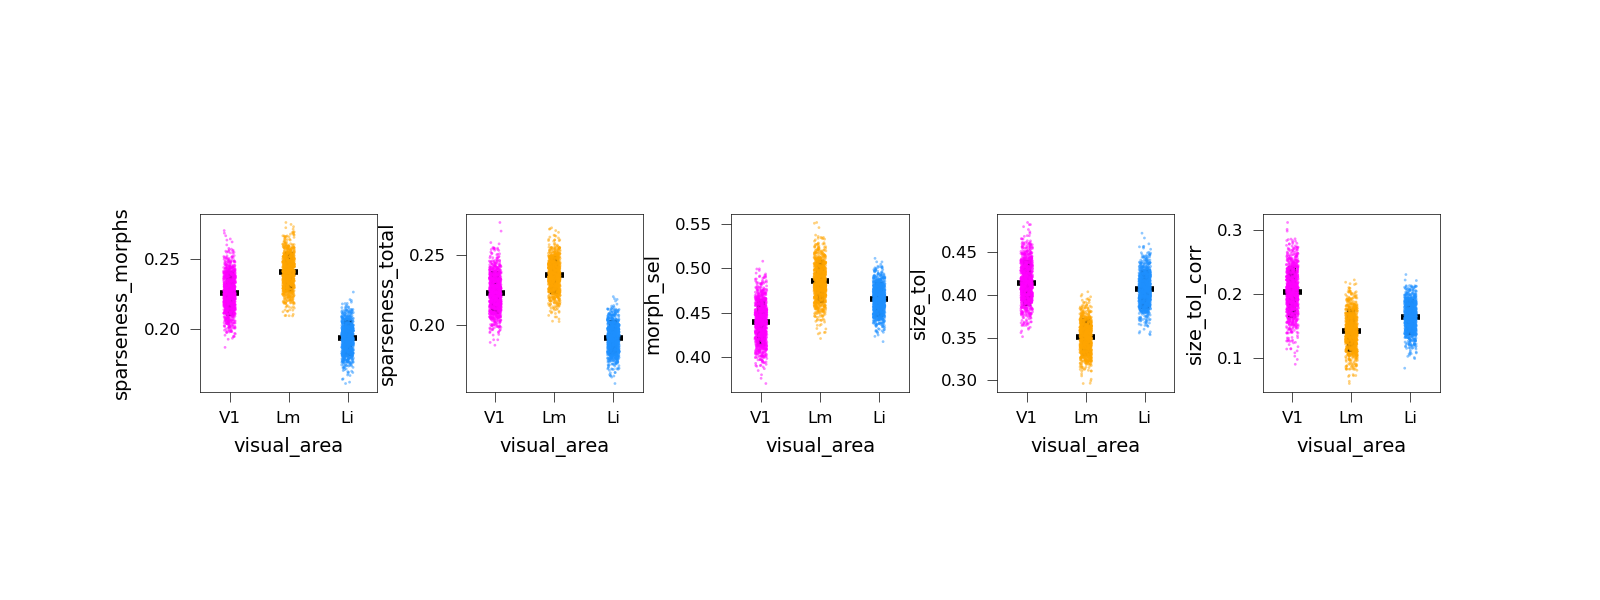

/tmp/ipykernel_4055259/4094029034.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=sampled_df, x='visual_area', y=v, ax=ax, s=1,
/tmp/ipykernel_4055259/4094029034.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=sampled_df, x='visual_area', y=v, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/tmp/ipykernel_4055259/4094029034.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=sampled_df, x='visual_area', y=v, ax=ax, s=1,
/tmp/ipykernel_4055259/4094029034.py:7: FutureWarning: 

The `ci`

In [202]:
#sampled_df
fig, axn = pl.subplots(1, len(plot_params), figsize=(8,3))
for i, v in enumerate(plot_params):
    ax=axn[i]
    sns.stripplot(data=sampled_df, x='visual_area', y=v, ax=ax, s=1,
                  order=['V1', 'Lm', 'Li'], alpha=0.5, palette=area_colors)
    sns.pointplot(data=sampled_df, x='visual_area', y=v, ax=ax, 
                  order=['V1', 'Lm', 'Li'], join=False, color='k',
                  estimator='median', markers='_', errwidth=3, ci='sd')
for ax in axn:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.5)

# Tradeoff

In [39]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

<IPython.core.display.Javascript object>


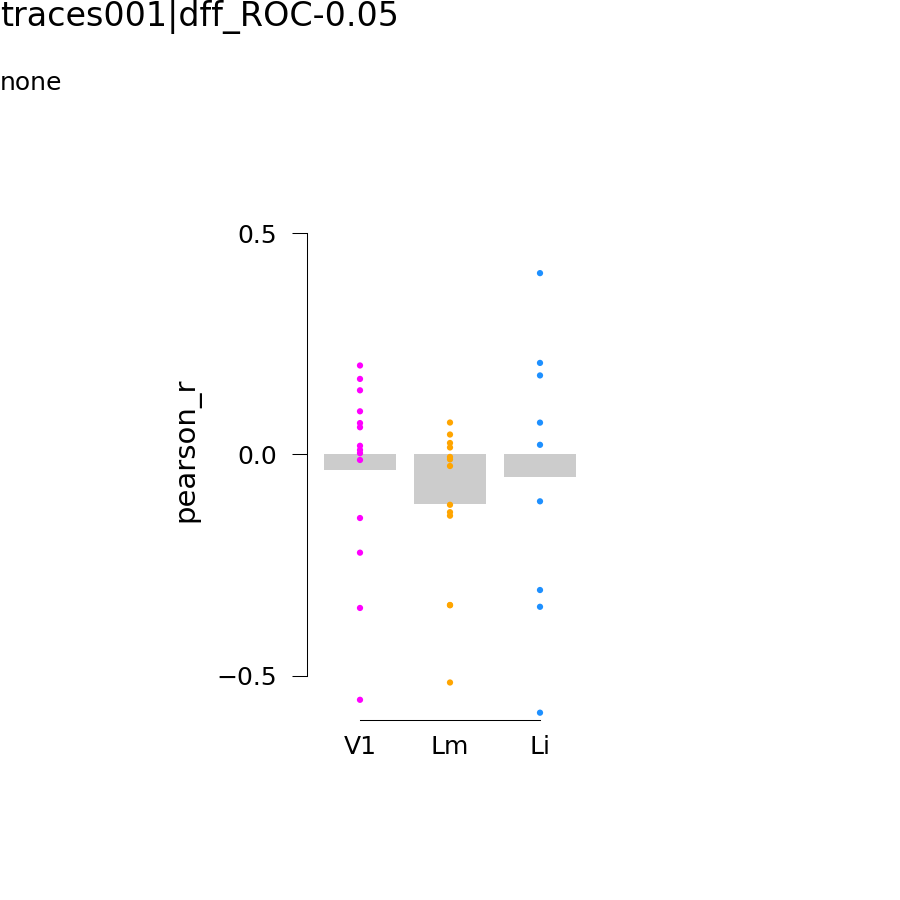

             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             9.0 -0.05  0.31 -0.58 -0.31  0.02  0.18  0.41
Lm            13.0 -0.11  0.18 -0.52 -0.14 -0.03  0.02  0.07
V1            14.0 -0.04  0.21 -0.55 -0.11  0.01  0.09  0.20
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus tradeoff-pearsonr_offset-none_lum-exclude_2
    A   B  p-unc  p-corr p-adjust     metric
0  V1  Lm   0.20    0.60     holm  pearson_r
1  V1  Li   0.83    0.85     holm  pearson_r
2  Lm  Li   0.42    0.85     holm  pearson_r


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:911: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  


In [40]:
metric = 'pearson_r'
y_loc=0.4
fig, ax = pl.subplots(figsize=(3, 3), dpi=150)
ax, sts = pplot.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                posthoc='holm',
                                sig_fontsize=4, jitter=False, aspect=2,
                                plot_means=True, y_loc=y_loc, offset=y_loc/15.,
                                mean_type='mean', mean_style='bar', return_stats=True)
ax.set_yticks(np.linspace(-1, 1, 5))
print(tradeoff.groupby('visual_area')[metric].describe().round(2))
ax.set_ylim([-0.6, 0.62])
sns.despine(trim=True, ax=ax)
pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = 'tradeoff-pearsonr_%s_2' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
print(sts.round(2))

In [205]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus'

<IPython.core.display.Javascript object>


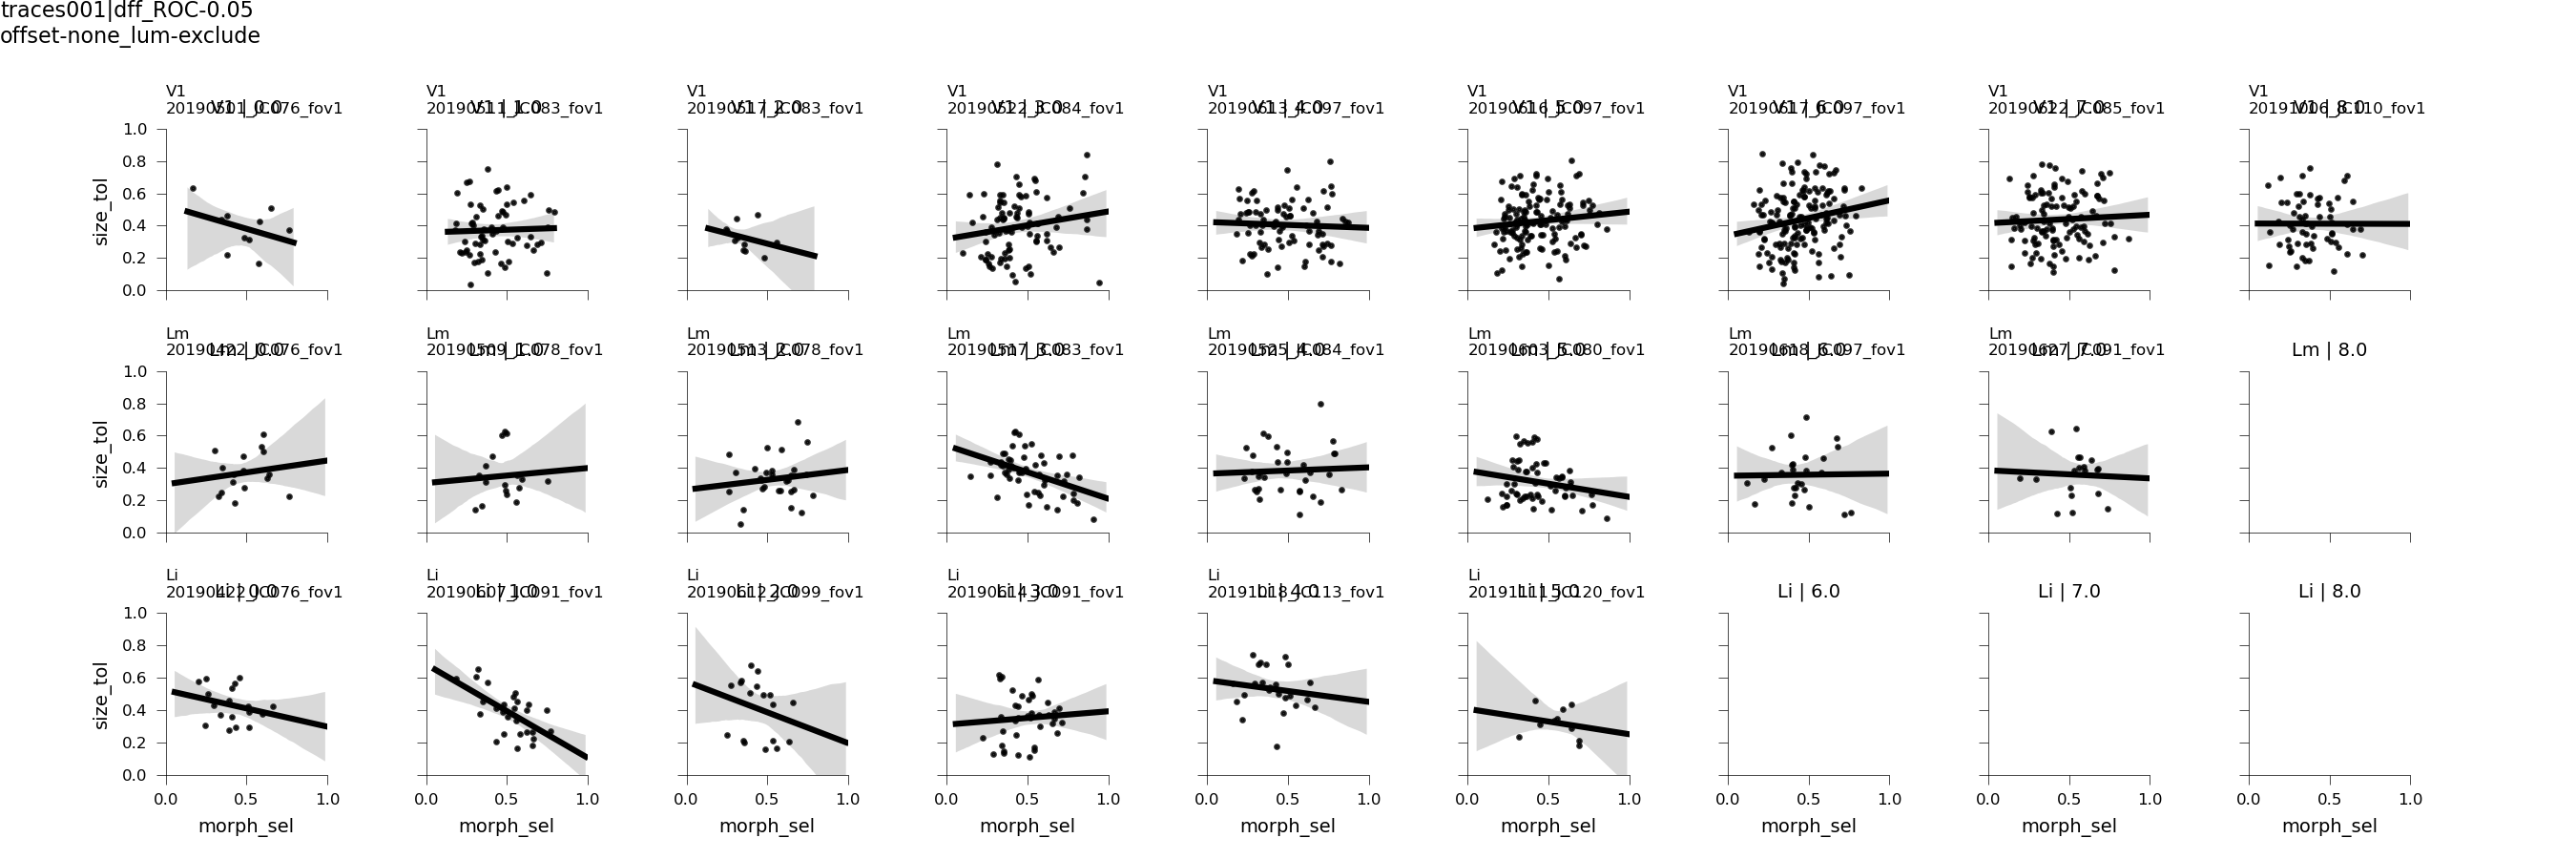

V1 0.0
V1 1.0
V1 2.0
V1 3.0
V1 4.0
V1 5.0
V1 6.0
V1 7.0
V1 8.0
Lm 0.0
Lm 1.0
Lm 2.0
Lm 3.0
Lm 4.0
Lm 5.0
Lm 6.0
Lm 7.0
Lm 8.0
Li 0.0
Li 1.0
Li 2.0
Li 3.0
Li 4.0
Li 5.0
Li 6.0
Li 7.0
Li 8.0
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus tradeoff_eachfov_offset-none_lum-exclude_2


In [206]:
fg = sns.FacetGrid(col='site_num', row='visual_area', row_order=visual_areas,
                   data=DF, height=1.5)
fg.map(sns.regplot, 'morph_sel', 'size_tol',
            truncate=False, color='k', scatter_kws={'s':2})
# DF["group"] = DF["site_num"].map(dict((k, v) for k, v in DF[['site_num', 'datakey']].values))

for ax in fg.axes.flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
pl.subplots_adjust(top=0.85)
    
[pl.setp(ax.texts, text="") for ax in fg.axes.flat] # remove the original texts
fg.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = fg.axes.flatten()
for ax in axes:
    currt = ax.get_title()
    va = currt.split(' ')[0]
    snum = float(currt.split(' ')[2])
    print(va, snum)
    dk = DF[(DF.visual_area==va) & (DF['site_num']==snum)]['datakey'].unique()
    if len(dk)==0:
        continue
    new_t = '%s\n%s' % (va, dk[0])
    ax.set_title(new_t, fontsize=6, loc='left')
pl.subplots_adjust(left=0.05, right=0.95, hspace=0.5)
fg.fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fg.fig, data_id)
figname = 'tradeoff_eachfov_%s_2' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


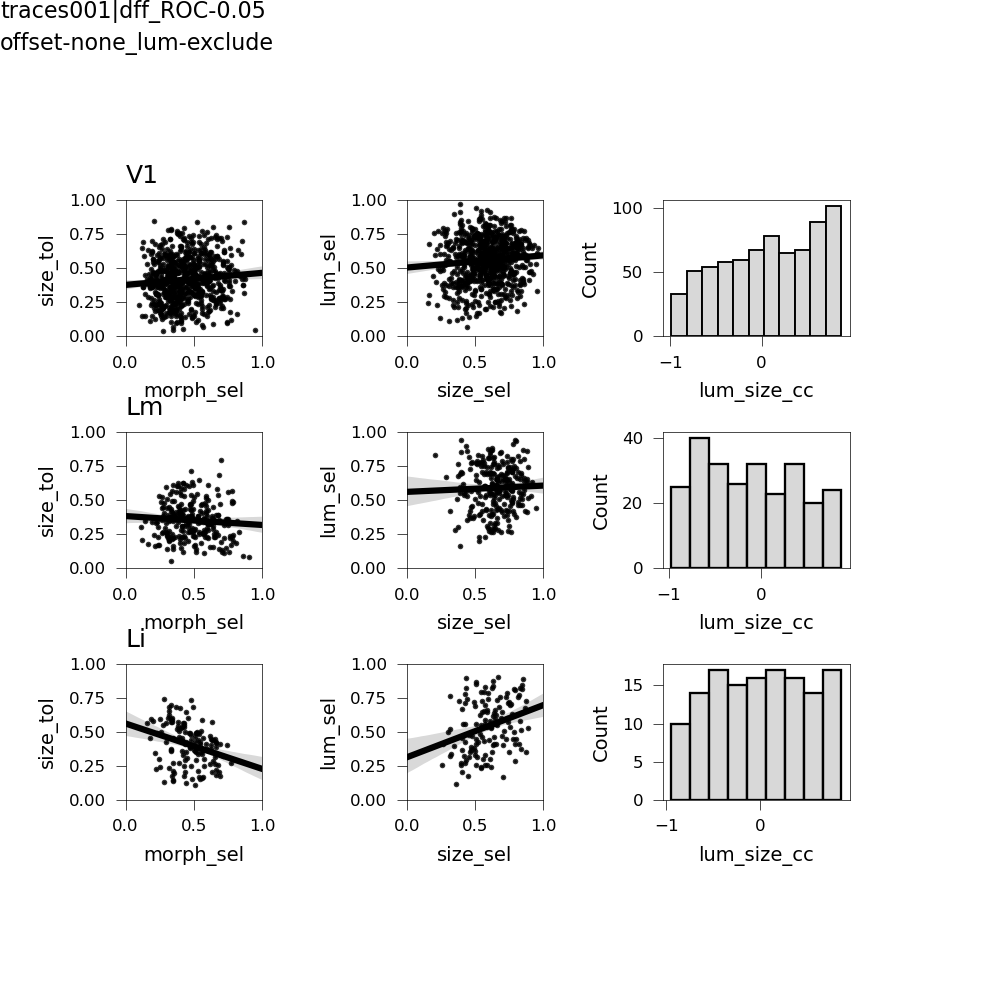

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus tradeoff_allcells_offset-none_lum-exclude_2


In [207]:
fig, axn = pl.subplots(3,3, figsize=(5,5))
for ax in axn[:, 0:-1].flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
for va, ixs_ in DF.dropna().groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[vi, 0]
    ax.set_title(va, loc='left')
    sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 1]
    sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 2]
    sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
                color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5,
                  hspace=0.7)

fig.text(0.0, 0.95, filter_str, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'tradeoff_allcells_%s_2' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Population sparseness

In [208]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [209]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
remove_offset=False # Set false, offsets removed if neg. in calculatin index
NDATA = NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
pop_sparse = sel.aggregate_population_sparseness(NDATA, offset_type=offset_type,
                                                lcorrection=lcorrection, )
popdf = pop_sparse[(pop_sparse['population_sparseness']<=1.0) 
                 & (pop_sparse['population_sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:600: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:600: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:600: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:600: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/obje

(1150, 5) (1150, 5)


In [210]:
pDF = popdf[popdf['n_cells']>=min_ncells].copy().dropna()
print(pDF.shape)
pop_by_fov = pDF.groupby(['visual_area', 'datakey']).mean().reset_index()
pop_by_config = pDF.groupby(['visual_area', 'config']).mean().reset_index()

(1150, 5)


/tmp/ipykernel_4055259/3806750628.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pop_by_fov = pDF.groupby(['visual_area', 'datakey']).mean().reset_index()
/tmp/ipykernel_4055259/3806750628.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pop_by_config = pDF.groupby(['visual_area', 'config']).mean().reset_index()


<IPython.core.display.Javascript object>


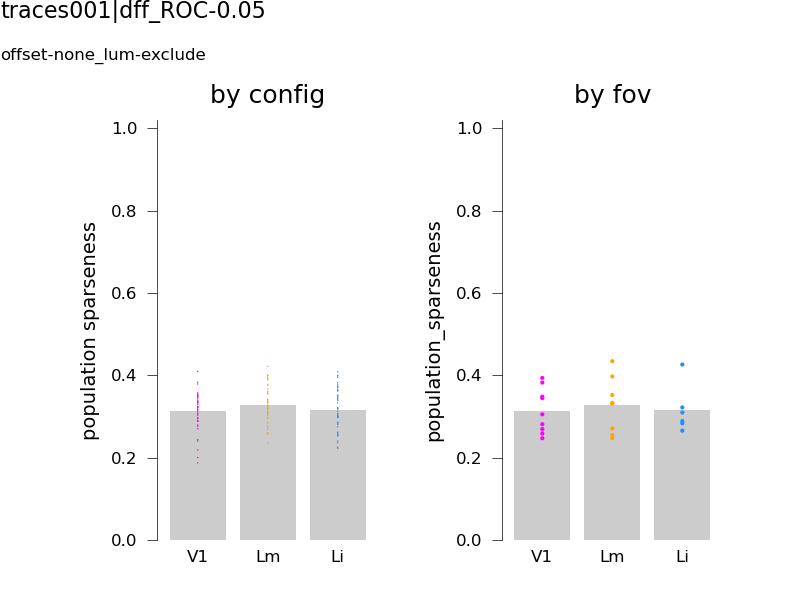

[mean]:
  visual_area  population_sparseness  population_sparseness_std
0          Li               0.316000                   0.048956
1          Lm               0.327748                   0.044571
2          V1               0.314486                   0.043889
[mean]:
  visual_area  population_sparseness  population_sparseness_std
0          Li               0.316000                   0.057571
1          Lm               0.327748                   0.067341
2          V1               0.314486                   0.054517


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:880: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pai

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final/ROC-stimulus population_sparseness_offset-none_lum-exclude


In [211]:
%matplotlib notebook
metric = 'population_sparseness'
multi_comp_test='fdr_bh' #'fdr_bh'

stat_cols = ['A', 'B', 'p-unc', 'p-corr', 'p-adjust', 'eta-square']
ylim = (0, 1.02)
y_loc = ylim[-1]-0.1

fig, axn = pl.subplots(1,2, figsize=(4,3))
for ai, ax in enumerate(axn.flat):
    plotdf = pop_by_config.dropna().copy() if ai==0 else pop_by_fov.copy()
    markersize = 1 if ai==0 else 3
    pplot.print_means(plotdf, groupby=['visual_area'], params=[metric], metric='mean')
    pplot.stripplot_metric_by_area(plotdf, metric=metric, ax=ax, mean_type='mean',
                            area_colors=area_colors, markersize=markersize,
                            y_loc=y_loc, sig_lw=0.2, offset=0.04, sig_fontsize=4,
                            ylim=ylim, aspect=2, mean_style='bar', jitter=False)
    ax.set_title('by config' if ai==0 else 'by fov')
fig.axes[0].set_ylabel('population sparseness')
pl.subplots_adjust(bottom=0.1, left=0.2, right=0.9, top=0.8, wspace=0.6)
fig.text(0.0, 0.9, filter_str, fontsize=6)

pplot.label_figure(fig, data_id)
figname = 'population_sparseness_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [171]:
'20190603_JC080_fov1' in NDATA0['datakey'].unique()

True

In [353]:
import analyze2p.extraction.traces as traceutils

In [354]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [355]:
dk = '20190506_JC080_fov1'
sdf = aggr.get_stimuli(dk, experiment='blobs')
soma_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       trace_type='np_subtracted')
raw_traces, labels, sdf, _ = traceutils.load_dataset(soma_fpath, 
                                    trace_type='corrected', add_offset=True, 
                                    create_new=True, save=False)

... processing data arrays, no save (corrected).
    adding raw offset (raw f0 offset: 551.30)
    adding raw offset (raw f0 offset: 93.05)


In [356]:
dff_traces, metrics = aggr.process_traces(raw_traces, labels, trace_type='dff',
                                        response_type='dff', 
                                        trial_epoch='stimulus')

--- processed traces: dff


In [357]:
metrics['visual_area'] = va
metrics['datakey'] = dk
metrics.loc[metrics.index, 'trial'] = metrics.index.tolist()

ndf = pd.melt(metrics, id_vars=['visual_area', 'datakey', 'config', 'trial'], var_name='cell', 
              value_name='response')

In [362]:
rdf0 = ndf.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
print(rdf0['response'].min(), rdf0['response'].max())
rdf = sel.correct_offset(rdf0, offset='minsub')
print(rdf['response'].min(), rdf['response'].max())

-2.039759962278916 0.7086775120989621
0.0 2.3673981233120944


In [363]:
ixs_ = sel.calculate_metrics(rdf, sdf)

<IPython.core.display.Javascript object>


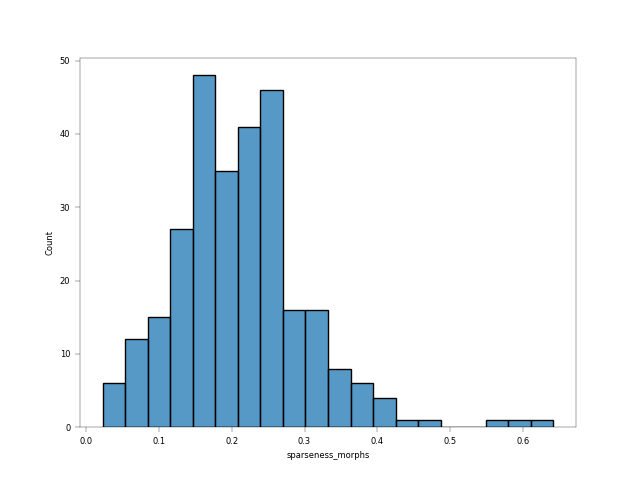

<AxesSubplot:xlabel='sparseness_morphs', ylabel='Count'>

In [364]:
# dk = '20190506_JC080_fov1'

fig, ax = pl.subplots()
sns.histplot(ixs_['sparseness_morphs'])


In [365]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].max()]


morph_sel  size_tol  sparseness_total  sparseness_morphs  \
68   0.931275  0.074335          0.618336           0.641299   

    sparseness_anchors  size_sel  lum_sel  lum_size_cc  lum_size_pval  cell  
68            0.233219  0.925665  0.75703    -0.217338        0.72547    68

In [366]:
ixs_[ixs_['sparseness_morphs']==ixs_['sparseness_morphs'].min()]


morph_sel  size_tol  sparseness_total  sparseness_morphs  \
26   0.153983  0.971997          0.020868           0.023009   

    sparseness_anchors  size_sel   lum_sel  lum_size_cc  lum_size_pval  cell  
26            0.000205  0.028003  0.080561    -0.723343       0.167243    26

In [86]:
import analyze2p.correlations as cr

In [87]:
def do_pairwise_diffs_melt(df_, metric_name='morph_sel', include_diagonal=False):
    pairwise_diffs = pd.DataFrame(abs(df_[metric_name].values \
                                  - df_[metric_name].values[:, None]), 
                              columns=df_['cell'].values, index=df_['cell'].values)

    diffs = cr.melt_square_matrix(pairwise_diffs, metric_name=metric_name)
    diffs = diffs.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    diffs[['cell_1', 'cell_2']] = diffs[['cell_1', 'cell_2']].astype(int)
    diffs['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in diffs[['cell_1', 'cell_2']].values]
    return diffs


In [88]:
DF['experiment'] = 'blobs'
DF = aggr.add_roi_positions(DF)

In [89]:
va = 'V1'
dk = '20191006_JC110_fov1'
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
df_.head()

morph_sel  size_tol  sparseness_total  sparseness_morphs  \
1337   0.592004  0.728200          0.175357           0.141727   
1338   0.113957  0.647360          0.129247           0.110111   
1339   0.276746  0.485549          0.237714           0.209670   
1340   0.399469  0.414261          0.229796           0.196078   
1341   0.431128  0.579382          0.233844           0.210213   

      sparseness_anchors  size_sel   lum_sel  lum_size_cc  lum_size_pval  \
1337            0.212171  0.271800  0.774502    -0.051729       0.934167   
1338            0.063657  0.352640  0.224575     0.088116       0.887952   
1339            0.218234  0.514451  0.772925     0.617586       0.266994   
1340            0.232018  0.585739  0.550042     0.207764       0.737383   
1341            0.202011  0.420618  0.522083    -0.489453       0.402673   

      cell  ... experiment animalid            fov   session    fov_xpos  \
1337     4  ...      blobs    JC110  FOV1_zoom2p0x  20191006  251.190607   
1338     5  ...      blobs    JC110  FOV1_zoom2p0x  20191006  235.059100   
1339    11  ...      blobs    JC110  FOV1_zoom2p0x  20191006  232.754599   
1340    24  ...      blobs    JC110  FOV1_zoom2p0x  20191006  163.619569   
1341    33  ...      blobs    JC110  FOV1_zoom2p0x  20191006  101.398043   

     fov_xpos_pix    fov_ypos fov_ypos_pix      ml_pos       ap_pos  
1337        109.0   51.400391         27.0  921.399609   926.409393  
1338        102.0   89.474755         47.0  883.325245   942.540900  
1339        101.0   72.341292         38.0  900.458708   944.845401  
1340         71.0  146.586301         77.0  826.213699  1013.980431  
1341         44.0  211.312720        111.0  761.487280  1076.201957  

[5 rows x 24 columns]

In [120]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='morph_sel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='lum_sel')
    d3 = do_pairwise_diffs_melt(df_, metric_name='size_tol')
    d4 = do_pairwise_diffs_melt(df_, metric_name='sparseness_morphs')
    
    diff_ = pd.merge(d1, d2).merge(d3).merge(d4)
    ddf_ = cr.get_pw_distance(diff_, roi_pos, )
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

In [121]:
fov_means = diffdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fov_means.head()

visual_area              datakey      cell_1      cell_2  morph_sel  \
0          Li  20190422_JC076_fov1  212.228070  290.824561   0.138830   
1          Li  20190602_JC091_fov1   73.975023  186.407956   0.176504   
2          Li  20190609_JC099_fov1  175.890476  243.942857   0.175799   
3          Li  20190614_JC091_fov1  154.052049  312.599114   0.138592   
4          Li  20191018_JC113_fov1   80.583333  122.216667   0.150761   

    lum_sel  size_tol  sparseness_morphs  cortical_distance  
0  0.212143  0.140246           0.101740         300.508467  
1  0.257779  0.165620           0.077016         241.740967  
2  0.193444  0.147620           0.067895         298.747585  
3  0.219539  0.153563           0.097312         304.634686  
4  0.193619  0.139770           0.073069         255.527099

<IPython.core.display.Javascript object>


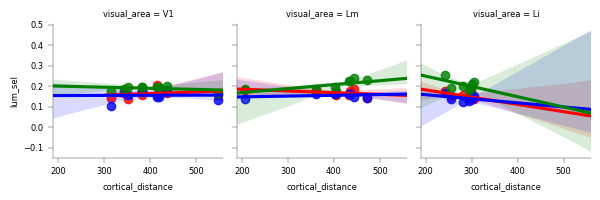

In [122]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fov_means, 
                  height=2)
fg.map(sns.regplot, 'cortical_distance', 'morph_sel', truncate=False,
      color='r')
fg.map(sns.regplot, 'cortical_distance', 'size_tol', truncate=False,
      color='b')
fg.map(sns.regplot, 'cortical_distance', 'lum_sel', truncate=False,
      color='g')

In [132]:
# Binning params
n_bins=100
use_quartile=False
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins)
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                                     use_quartile=use_quartile, return_bins=True,
                                     n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


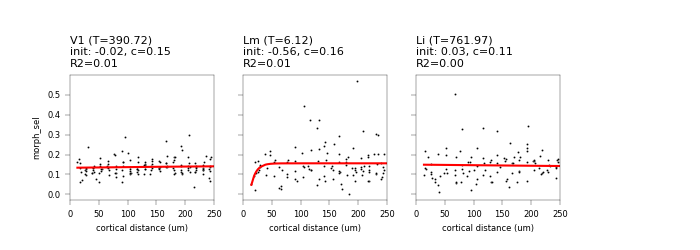

In [133]:
metric = 'morph_sel'
fit_sites=True
min_npairs = 3
n_iter=0
x_var = 'binned_%s' % to_quartile
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    pair_cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(pair_cnts[pair_cnts>min_npairs].index.tolist(),
                               pair_cnts[pair_cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)[metric].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y=metric, data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, #bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
    ax.set_xlim([0, 250])
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)


In [112]:
va, dk

('V1', '20191006_JC110_fov1')

<IPython.core.display.Javascript object>


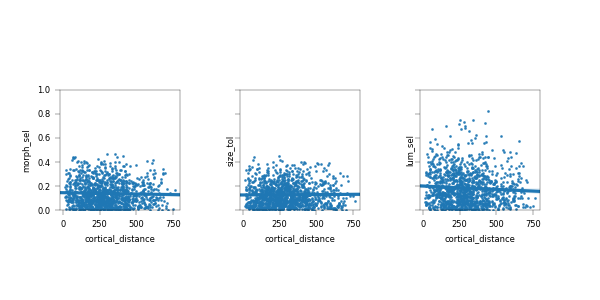

In [98]:
va='Li'
dk='20191105_JC117_fov1'
df_ = diffdf[(diffdf.visual_area==va) & (diffdf.datakey==dk)]

fig, axn = pl.subplots(1,3, figsize=(6, 3), sharex=True, sharey=True)
for ax, metric in zip(axn.flat, ['morph_sel', 'size_tol', 'lum_sel']):
    ax.set_ylim([0, 1])
    #ax.set_aspect('equal')
    sns.regplot(x='cortical_distance', y=metric, data=df_, ax=ax,
               truncate=False, scatter_kws={'s':1})
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


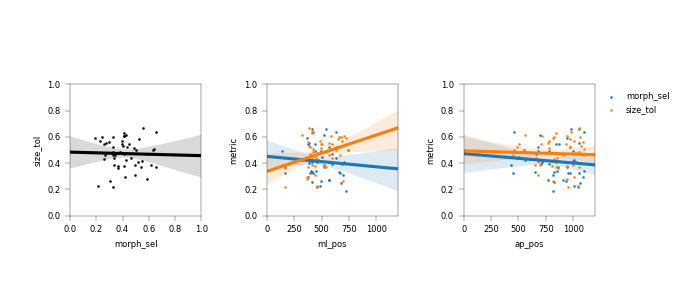

In [99]:
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
fig, axn = pl.subplots(1, 3, figsize=(7, 3), sharex=False, sharey=False)
ax=axn[0]
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_aspect('equal')
sns.regplot(x='morph_sel', y='size_tol', ax=ax, data=df_,
           truncate=False, color='k', scatter_kws={'s':1})

for ax, axis in zip(axn.flat[1:], ['ml_pos', 'ap_pos']):
    ax.set_ylim([0,1])
    ax.set_xlim([0, 1200])
    sns.regplot(x=axis, y='morph_sel', ax=ax, data=df_, label='morph_sel',
               truncate=False, scatter_kws={'s':1})
    sns.regplot(x=axis, y='size_tol', ax=ax, data=df_, label='size_tol',
               truncate=False, scatter_kws={'s':1})
    ax.set_ylabel('metric')
    #ax.set_aspect(0.1)
    #force_aspect(ax,aspect=1)
    ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [100]:
def get_best_x(rd):
    '''
    Get best morph and best size (rd=ndf[ndf.cell==x])
    '''
    sizr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='size', y='morphlevel', normalize=False)
    best_mp = int(sizr['morphlevel'].unique())

    morphr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='morphlevel', y='size', normalize=False)
    best_sz = int(morphr['size'].unique())

    return pd.Series({'morphlevel': best_mp, 'size': best_sz})



In [101]:
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    ndf = pd.concat([NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) 
              & (NDATA.cell.isin(g['cell'].unique()))] \
                for (va, dk), g in df_.groupby(['visual_area', 'datakey'])]).copy()
    ndf['size'] = sdf.loc[ndf['config'].values]['size'].values
    ndf['morphlevel'] = sdf.loc[ndf['config'].values]['morphlevel'].values
    bestvs = ndf.groupby('cell').apply(get_best_x)
    df_['best_morphlevel'] = bestvs.loc[df_['cell'].values]['morphlevel'].values
    df_['best_size'] = bestvs.loc[df_['cell'].values]['size'].values
    DF.loc[df_.index, 'best_morphlevel'] = df_['best_morphlevel']
    DF.loc[df_.index, 'best_size'] = df_['best_size']

<IPython.core.display.Javascript object>


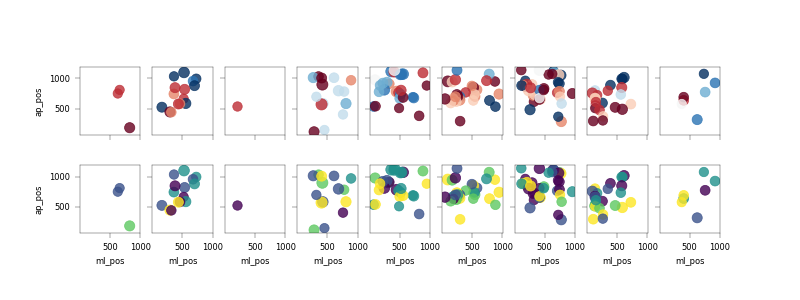

<IPython.core.display.Javascript object>


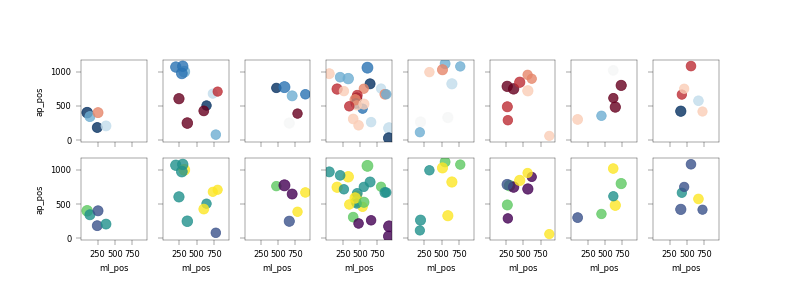

<IPython.core.display.Javascript object>


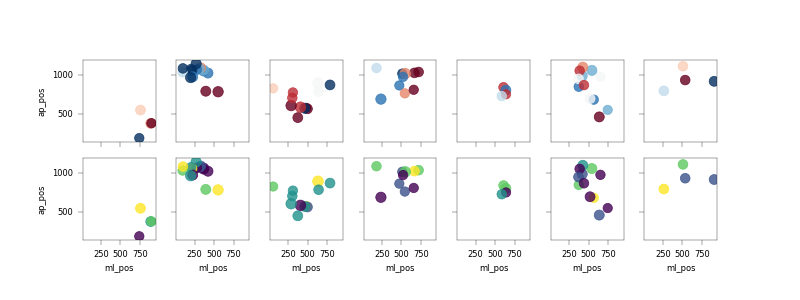

In [149]:
for va in visual_areas:
    plotd = DF[(DF.visual_area==va) & (DF['morph_sel']>=0.5)].copy()

    n_fovs = len(plotd['datakey'].unique())
    fig, axn = pl.subplots(2, n_fovs, figsize=(8, 3), sharex=True, sharey=True)
    size_value='morph_sel'

    for di, (dk, df_) in enumerate(plotd.groupby(['datakey'])):

        for hi, hue_name in enumerate(['best_morphlevel', 'best_size']):
            ax = axn[hi, di]
            metric_cmap = 'RdBu' if hue_name=='best_morphlevel' else 'viridis'
            hue_norm = (0, 106) if hue_name=='best_morphlevel' else (10, 50) 
            sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax, 
                        size=size_value, size_norm=(0, 1), palette=metric_cmap,
                        hue=hue_name, hue_norm=hue_norm, marker='o',
                        edgecolor=None, alpha=0.8, legend=False)
            ax.set_aspect('equal')
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


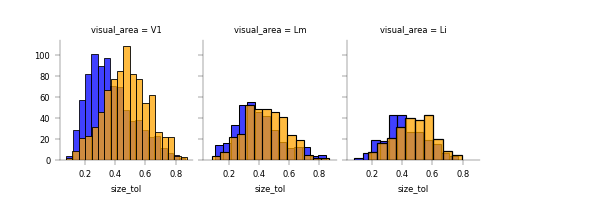

In [150]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=DF,
                  height=2)
fg.map(sns.histplot, 'morph_sel', color='blue')
fg.map(sns.histplot, 'size_tol', color='orange')

pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


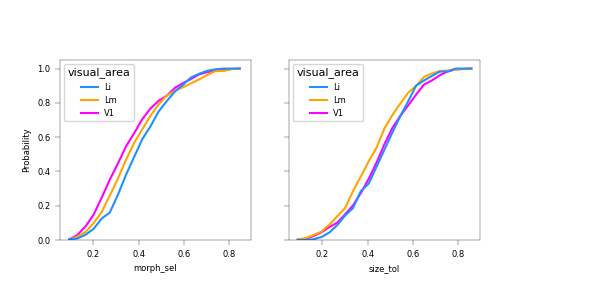

In [108]:
fig, axn=pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
sns.histplot(x='morph_sel', hue='visual_area', data=DF, ax=axn[0],
            palette=area_colors, stat='probability', fill=False,
            cumulative=True, common_norm=False, element='poly')
sns.histplot(x='size_tol', hue='visual_area', data=DF, ax=axn[1],
            palette=area_colors, stat='probability',fill=False,
            cumulative=True, common_norm=False, element='poly')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

In [179]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='best_morphlevel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='best_size')
    diff_ = pd.merge(d1, d2)
    ddf_ = cr.get_pw_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
bestdiffs = pd.concat(d_, axis=0, ignore_index=True)

In [185]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
n_iterations=500
n_samples=None
# ------------------------------
# Get bins
to_quartile='cortical_distance'
n_bins=100
use_quartile=False
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
# Bin ---------------------------------------------------
bcorrs, bins_ = cr.bin_column_values(bestdiffs, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]


<IPython.core.display.Javascript object>


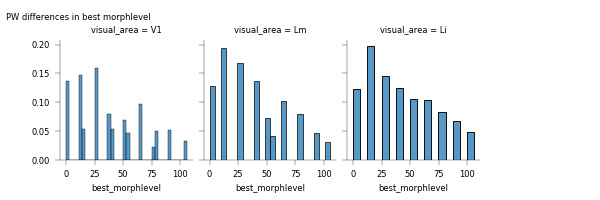

Text(0.01, 0.9, 'PW differences in best morphlevel')

In [186]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2, data=bestdiffs)
fg.map(sns.histplot, 'best_morphlevel', stat='probability', common_norm=False)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

fg.fig.text(0.01, 0.9, 'PW differences in best morphlevel')

<IPython.core.display.Javascript object>


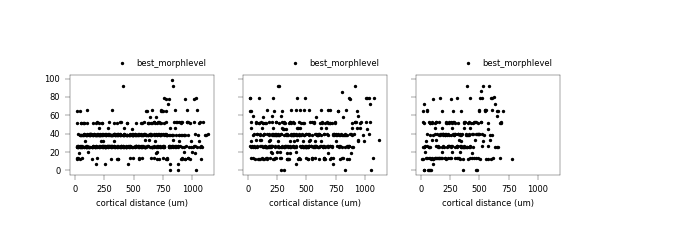

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: Lm
    val out of bounds
BINNED, no fit: V1


In [187]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
metric = 'best_morphlevel'
fit_sites = True
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    ax.scatter(x=to_quartile, y=metric, data=fov_cc, 
                s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [188]:
min_ncells=20
final_counts = DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_ds = final_counts[ (final_counts['cell']>=min_ncells)]

In [189]:
max_nfovs = curr_ds['visual_area'].value_counts().max()
max_nfovs

8

<IPython.core.display.Javascript object>


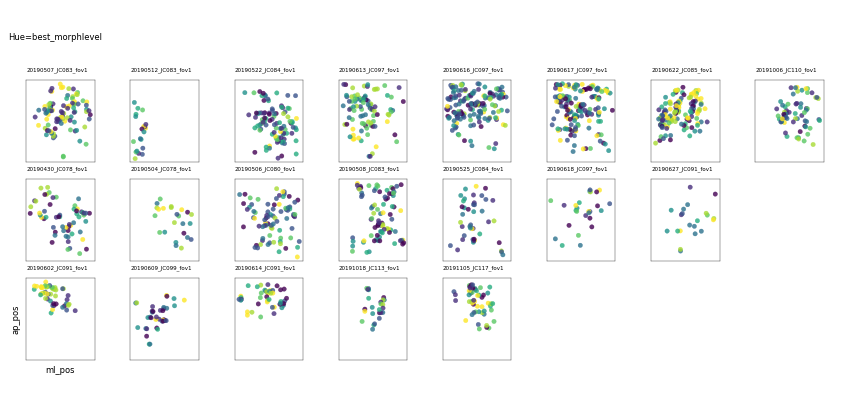

Text(0.01, 0.9, 'Hue=best_morphlevel')

In [192]:
metric = 'best_morphlevel'
cmap='viridis'
fig, axn = pl.subplots(3, max_nfovs, sharex=True, sharey=True, figsize=(8.5,4))
for va, curr_ in curr_ds.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, (va, dk, nc) in enumerate(curr_.values):
        ax=axn[vi, ai]
        ax.set_title(dk, fontsize=4, loc='left')
        df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]

        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=10, 
                        edgecolor=None, alpha=0.8, legend=False)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axn[vi, ai+1:].flat:
        ax.axis('off')
pl.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.8)
fig.text(0.01, 0.9, 'Hue=%s' % metric)

<IPython.core.display.Javascript object>


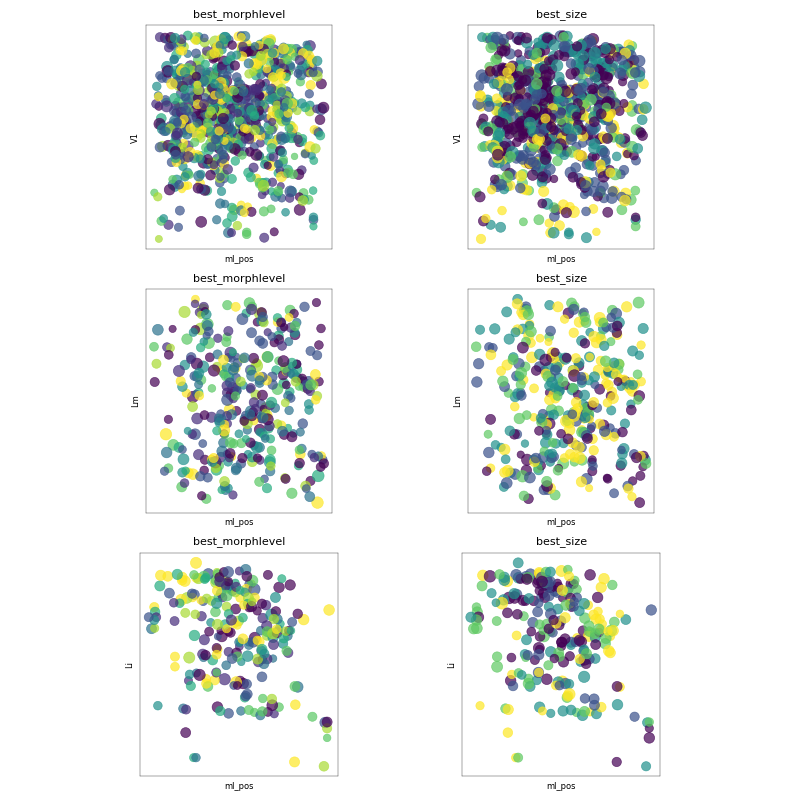

In [193]:

metric_list = ['morph_sel', 'size_tol', 'lum_sel']
metric_list = ['best_morphlevel', 'best_size']

fig, axn = pl.subplots(3,len(metric_list), figsize=(8,8))

for va, df_ in DF.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, metric in enumerate(metric_list):
        ax=axn[vi, ai]
        size_value = 'size_tol' if 'size' in metric else 'morph_sel'
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, size=size_value,
                        size_norm=(0, 0.8),
                        edgecolor=None, alpha=0.7, legend=False,
                        vmin=0, vmax=1)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_title(metric)
        ax.set_ylabel(va)
        ax.set_xticks([])
        ax.set_yticks([])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.8, wspace=0.2, hspace=0.4)
pl.tight_layout()